## Testando Viés e Encontrando modelo final
1 - Criar uma coluna de 12 safras e dividir a nova base em desenvolvimento (10 safras) e OOT (2 safras). ✔️

2 - Análise descritiva das variáveis: categóricas (valores, significado, freq com histograma), contínuas (violinplot, distribuição de frequência com histograma, outliers) ✔️

3 - Análise de missing values na base toda, excluir colunas com +50% de missing, pesquisar quais maneiras de tratar os missings e se vale a pena substituí-los pela média/moda. ✔️

4 - Análise de balanceamento de classe: formar uma nova base aleatória em que 50% das linhas tenham default_evento igual a 0 e 50% igual a 1. Pesquisar melhor forma para fazer isso (não adianta deixar todos 1s, e aleatorizar os 0s. Lembrar de manter proporção de volume por safra. Conclusão: balancear no item 8 ao fazer k-fold ✔️

5 - Otimização das variáveis (categorizar todas, inclusive as categóricas - optimal bining + get_dummies). Pesquisar função que transforme uma variável para otimizar seu IV (log dela, por exemplo). ✔️

6 - Análise de correlação de variáveis. Caso a correlação seja >70%, excluir a variável de menor IV. ✔️

7 - Dividir o desenvolvimento em 80% treino e 20% teste. ✔️

8 - Treinar o modelo com k-fold cross validation e encontrar a AUC aplicando o modelo treinado no teste. ✔️

9 - Colocar como hiperparâmetro do scikit 5 vezes de k-fold e AUC como métrica ✔️

10 - Se a diferença entre a maior e a menor AUC for menor que 3%, os dados não estão viesados. ✔️

11 - Após garantir que os dados não estão viesados, treinar o modelo final com toda base nova. ✔️

12 - Calcular a AUC aplicando o modelo final no OOT (transformar o OOT para ter as mesmas variáveis categóricas do desenvolvimento) ✔️


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from dython import nominal
from optbinning import OptimalBinning
from optbinning import BinningProcess
from feature_engine.transformation import LogTransformer, LogCpTransformer, ReciprocalTransformer, PowerTransformer, BoxCoxTransformer, YeoJohnsonTransformer, ArcsinTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

(CVXPY) Feb 24 04:35:23 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 24 04:35:23 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# Necessário rodar sempre

In [2]:
df = pd.read_excel('default of credit card clients.xls', header = 1)
pd.options.display.max_columns = None
safras = [202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111, 202112]
df['safras'] = [random.choice(safras) for i in range(df.shape[0])]
df.rename(columns={'default payment next month':'alvo'}, inplace=True)

In [3]:
pays=['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df_var = df.drop(columns = ['ID', 'alvo', 'safras']).drop(columns=pays)
for col in df_var.columns.values:
    try:
        df[f'{col}_LOG'] = LogTransformer(variables=None, base='e').fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_LOGC'] = LogCpTransformer(variables=None, base='e', C='auto').fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_REC'] = ReciprocalTransformer(variables=None).fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_POW'] = PowerTransformer(variables=None, exp=0.5).fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_BOX'] = BoxCoxTransformer(variables=None).fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_YEO'] = YeoJohnsonTransformer(variables=None).fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass
    try:
        df[f'{col}_ARC'] = ArcsinTransformer(variables=None).fit_transform(pd.DataFrame(df[col]), df['alvo'])
    except:
        pass

In [4]:
df['SEX'] = np.where((df['SEX']==1) , 'male', 'female')

df['EDUCATION'].replace({1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others', 5:'missing', 6:'missing', 0:'missing'}, inplace=True)

df['MARRIAGE'].replace({1: 'married', 2: 'single', 3: 'others', 0:'missing'}, inplace=True)

In [5]:
des = [202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110]
oot = [202111, 202112]
df_des=pd.DataFrame()
df_oot=pd.DataFrame()


for col in pays:
    df[col].replace({-2:'-2', -1:'-1', 0:'0', 1:'1', 2:'2', 3:'3+', 4:'3+', 5:'3+', 6:'3+', 7:'3+', 8:'3+'}, inplace=True)

for i in des:
    df_des = pd.concat([df_des, df[df['safras']==i]], axis=0)

for j in oot:
    df_oot = pd.concat([df_oot, df[df['safras']==j]], axis=0)

In [6]:
categorical_variables = [ 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [7]:
binning_process  = BinningProcess(list(df_des.drop(columns='alvo').columns.values), categorical_variables=categorical_variables, min_prebin_size = 0.05,max_n_bins=5)
binning_process.fit(df_des.drop(columns='alvo'), df_des['alvo'])
pd.options.display.max_rows = 90
binning_process.summary().sort_values(by=['iv'], ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,PAY_0,categorical,OPTIMAL,True,5,0.883874,0.09852,0.425988,0.072661
7,PAY_2,categorical,OPTIMAL,True,4,0.538571,0.062736,0.298091,0.102199
8,PAY_3,categorical,OPTIMAL,True,4,0.414435,0.048793,0.26455,0.563212
9,PAY_4,categorical,OPTIMAL,True,4,0.363624,0.042569,0.239289,0.531411
10,PAY_5,categorical,OPTIMAL,True,4,0.343914,0.03986,0.221496,0.540199
11,PAY_6,categorical,OPTIMAL,True,4,0.29316,0.034386,0.20591,0.64462
67,PAY_AMT1_LOGC,numerical,OPTIMAL,True,5,0.182711,0.022396,0.225279,0.606865
68,PAY_AMT1_POW,numerical,OPTIMAL,True,5,0.182711,0.022396,0.225279,0.606865
69,PAY_AMT1_YEO,numerical,OPTIMAL,True,5,0.182711,0.022396,0.225279,0.606865
18,PAY_AMT1,numerical,OPTIMAL,True,5,0.182711,0.022396,0.225279,0.606865


In [8]:
X_train_transf = binning_process.transform(df_des.drop(columns='alvo'),metric='bins')
X_oot_transf = binning_process.transform(df_oot.drop(columns='alvo'),metric='bins')
X_train_transf.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,safras,LIMIT_BAL_LOG,LIMIT_BAL_LOGC,LIMIT_BAL_REC,LIMIT_BAL_POW,LIMIT_BAL_BOX,LIMIT_BAL_YEO,SEX_LOG,SEX_LOGC,SEX_REC,SEX_POW,SEX_BOX,SEX_YEO,EDUCATION_LOGC,EDUCATION_POW,EDUCATION_YEO,MARRIAGE_LOGC,MARRIAGE_POW,MARRIAGE_YEO,AGE_LOG,AGE_LOGC,AGE_REC,AGE_POW,AGE_BOX,AGE_YEO,BILL_AMT1_LOGC,BILL_AMT1_POW,BILL_AMT1_YEO,BILL_AMT2_LOGC,BILL_AMT2_POW,BILL_AMT2_YEO,BILL_AMT3_LOGC,BILL_AMT3_POW,BILL_AMT3_YEO,BILL_AMT4_LOGC,BILL_AMT4_POW,BILL_AMT4_YEO,BILL_AMT5_LOGC,BILL_AMT5_POW,BILL_AMT5_YEO,BILL_AMT6_LOGC,BILL_AMT6_POW,BILL_AMT6_YEO,PAY_AMT1_LOGC,PAY_AMT1_POW,PAY_AMT1_YEO,PAY_AMT2_LOGC,PAY_AMT2_POW,PAY_AMT2_YEO,PAY_AMT3_LOGC,PAY_AMT3_POW,PAY_AMT3_YEO,PAY_AMT4_LOGC,PAY_AMT4_POW,PAY_AMT4_YEO,PAY_AMT5_LOGC,PAY_AMT5_POW,PAY_AMT5_YEO,PAY_AMT6_LOGC,PAY_AMT6_POW,PAY_AMT6_YEO
0,"(-inf, 18524.50)","(-inf, 45000.00)",['female'],['university'],['married' 'others'],"(-inf, 25.50)",['2' '3+'],['2' '3+'],['1' '-1'],['-1'],['-2'],['-2'],"[2561.00, 5161.50)","[2603.50, 7871.00)","[464.50, 2765.50)","(-inf, 787.50)","(-inf, 390.50)","(-inf, 117.00)","(-inf, 21.00)","[91.00, 1602.50)","(-inf, 6.50)","(-inf, 0.50)","(-inf, 5.50)","(-inf, 1.50)","(-inf, 202108.50)","(-inf, 10.71)","(-inf, 10.91)","[0.00, inf)","(-inf, 211.80)","(-inf, 61.79)","(-inf, 61.79)","[0.35, inf)","[1.24, inf)","(-inf, 0.75)","[1.21, inf)","[0.70, inf)","[6.16, inf)","[0.90, 1.24)","[1.21, 1.57)","[0.78, 1.03)","(-inf, 0.90)","(-inf, 1.21)","(-inf, 1.28)","(-inf, 3.24)","(-inf, 3.86)","[0.04, inf)","(-inf, 5.05)","(-inf, 1.66)","(-inf, 1.59)","[12.03, 12.05)","[50.61, 71.84)","[1052.38, 1935.38)","[11.19, 11.26)","[51.02, 88.72)","[841.63, 2117.45)","[11.97, 11.98)","[21.55, 52.59)","[225.25, 1042.98)","(-inf, 12.05)","(-inf, 28.06)","(-inf, 373.59)","(-inf, 11.31)","(-inf, 19.76)","(-inf, 183.01)","(-inf, 12.74)","(-inf, 20.46)","(-inf, 81.63)","(-inf, 3.09)","(-inf, 4.58)","(-inf, 4.39)","[4.52, 7.38)","[9.54, 40.03)","[7.42, 17.14)","(-inf, 2.01)","(-inf, 2.55)","(-inf, 2.44)","(-inf, 0.35)","(-inf, 0.50)","(-inf, 0.37)","(-inf, 1.87)","(-inf, 2.34)","(-inf, 2.20)","(-inf, 0.90)","(-inf, 1.21)","(-inf, 0.97)"
1,"(-inf, 18524.50)","[45000.00, 125000.00)",['female'],['university'],['missing' 'single'],"[25.50, 28.50)",['-1'],['2' '3+'],['0'],['0'],['0'],['2' '3+'],"[2561.00, 5161.50)","[707.50, 2603.50)","[464.50, 2765.50)","[2897.00, 8290.50)","[2551.00, 8172.50)","[2501.50, 5418.00)","(-inf, 21.00)","[91.00, 1602.50)","[6.50, 1600.50)","[0.50, 2004.50)","(-inf, 5.50)","[1.50, 2000.50)","(-inf, 202108.50)","[10.71, 11.74)","[10.91, 11.81)","[0.00, 0.00)","[211.80, 353.48)","[61.79, 82.47)","[61.79, 82.46)","[0.35, inf)","[1.24, inf)","(-inf, 0.75)","[1.21, inf)","[0.70, inf)","[6.16, inf)","[0.90, 1.24)","[1.21, 1.57)","[0.78, 1.03)","[0.90, inf)","[1.21, inf)","[1.28, inf)","[3.24, 3.35)","[3.86, 3.92)","[0.04, 0.04)","[5.05, 5.34)","[1.66, 1.69)","[1.59, 1.61)","[12.03, 12.05)","[50.61, 71.84)","[1052.38, 1935.38)","[11.16, 11.19)","[20.46, 51.02)","[283.61, 841.63)","[11.97, 11.98)","[21.55, 52.59)","[225.25, 1042.98)","[12.06, 12.09)","[53.82, 91.05)","[1157.37, 2881.30)","[11.34, 11.40)","[50.51, 90.40)","[897.73, 2404.25)","[12.74, 12.75)","[50.01, 73.61)","[1309.73, 2635.61)","(-inf, 3.09)","(-inf, 4.58)","(-inf, 4.39)","[4.52, 7.38)","[9.54, 40.03)","[7.42, 17.14)","[2.01, 7.38)","[2.55, 40.01)","[2.44, 15.86)","[0.35, 7.60)","[0.50, 44.77)","[0.37, 15.69)","(-inf, 1.87)","(-inf, 2.34)","(-inf, 2.20)","[0.90, 7.60)","[1.21, 44.73)","[0.97, 14.61)"
2,"(-inf, 18524.50)","[125000.00, 225000.00)",['female'],['high school'],['missing' 'single'],"[33.50, 45.50)",['0'],['0'],['2' '3+'],['0'],['0'],['-1'],"[5161.50, 12433.00)","[7871.00, 11987.00)","[2765.50, 7602.00)","[787.50, 2897.00)","[390.50, 2551.00)","[2501.50, 5418.00)","[2000.50, 4808.00)","(-inf, 91.00)","[6.50, 1600.50)","[0.50,

In [9]:
selecionadas = ['EDUCATION', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT4', 'LIMIT_BAL_YEO', 
                'AGE_LOGC', 'BILL_AMT1_POW', 'BILL_AMT4_POW', 'BILL_AMT5_POW', 'BILL_AMT6_POW', 
                'PAY_AMT1_LOGC','PAY_AMT2_POW', 'PAY_AMT3_LOGC','PAY_AMT5_YEO', 'PAY_AMT6_YEO']

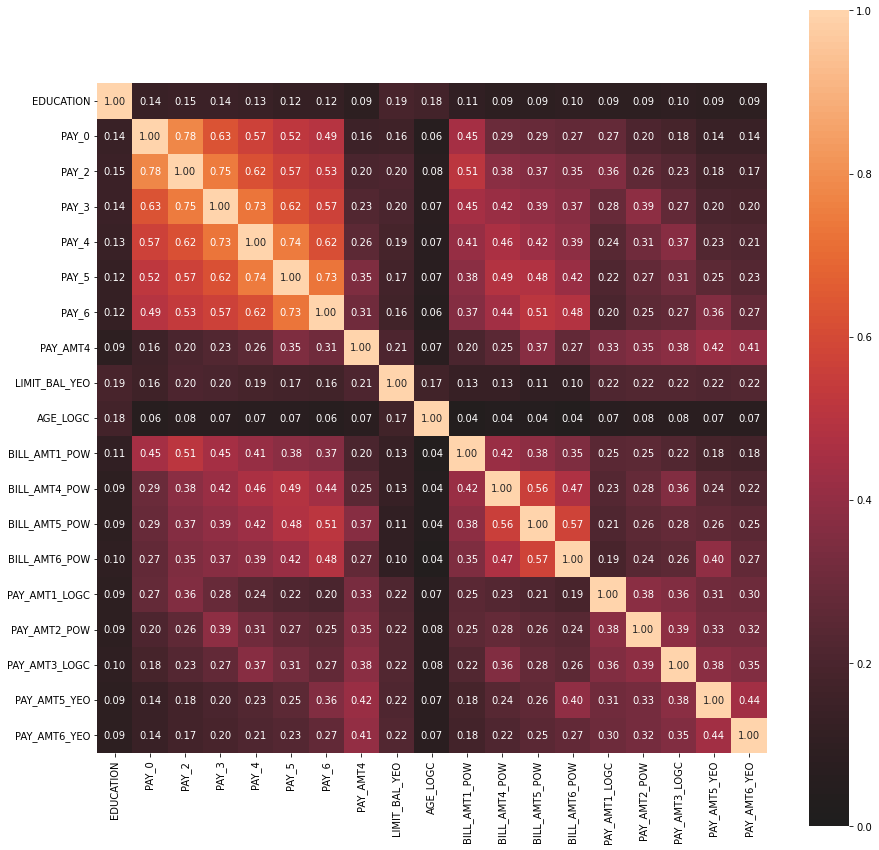

{'corr':                EDUCATION     PAY_0     PAY_2     PAY_3     PAY_4     PAY_5  \
 EDUCATION       1.000000  0.137687  0.148392  0.144628  0.134295  0.120924   
 PAY_0           0.137687  1.000000  0.779023  0.629412  0.566046  0.523285   
 PAY_2           0.148392  0.779023  1.000000  0.747115  0.624150  0.569064   
 PAY_3           0.144628  0.629412  0.747115  1.000000  0.734018  0.619880   
 PAY_4           0.134295  0.566046  0.624150  0.734018  1.000000  0.743218   
 PAY_5           0.120924  0.523285  0.569064  0.619880  0.743218  1.000000   
 PAY_6           0.117302  0.492480  0.531420  0.568764  0.616586  0.733915   
 PAY_AMT4        0.093101  0.155579  0.196005  0.225124  0.256388  0.346430   
 LIMIT_BAL_YEO   0.192127  0.162405  0.203398  0.197083  0.185251  0.173098   
 AGE_LOGC        0.177345  0.062440  0.075912  0.073413  0.070084  0.066232   
 BILL_AMT1_POW   0.106749  0.446729  0.510350  0.448653  0.409987  0.381056   
 BILL_AMT4_POW   0.093559  0.294895  0.38104

In [10]:
display(nominal.associations(X_train_transf[selecionadas], nominal_columns='all', figsize=(15,15)))

In [11]:
selecionadas2 = ['EDUCATION', 'PAY_0', 'PAY_3', 'PAY_5', 'PAY_AMT4', 'LIMIT_BAL_YEO', 
                'AGE_LOGC', 'BILL_AMT1_POW', 'BILL_AMT4_POW', 'BILL_AMT5_POW', 'BILL_AMT6_POW', 
                'PAY_AMT1_LOGC','PAY_AMT2_POW', 'PAY_AMT3_LOGC','PAY_AMT5_YEO', 'PAY_AMT6_YEO']

In [12]:
df_des.reset_index(drop=True, inplace=True)
df_oot.reset_index(drop=True, inplace=True)

In [13]:
df_des_dummies = pd.DataFrame()
df_oot_dummies = pd.DataFrame()
for col in selecionadas2:
    df_provs = pd.get_dummies(X_train_transf[col], prefix=col, prefix_sep=': ')
    df_provsoot = pd.get_dummies(X_oot_transf[col], prefix=col, prefix_sep=': ')
    df_des_dummies=pd.concat([df_des_dummies, df_provs], axis=1)
    df_oot_dummies=pd.concat([df_oot_dummies, df_provsoot], axis=1)

    
df_des_dummies=pd.concat([df_des_dummies, df_des['alvo']], axis=1)
print(df_des_dummies.shape)
df_oot_dummies=pd.concat([df_oot_dummies, df_oot['alvo']], axis=1)
print(df_oot_dummies.shape)

(25005, 81)
(4995, 81)


,Feature name,Coefficients
0,Intercept,0.019435
1,EDUCATION: ['high school'],0.000602
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.045259
3,EDUCATION: ['university'],0.060840
4,PAY_0: ['-1'],-0.379843
5,PAY_0: ['-2'],-0.450159
6,PAY_0: ['0'],-0.761850
7,PAY_0: ['1'],0.035162
8,PAY_0: ['2' '3+'],1.572872
9,PAY_3: ['-2'],-0.398100


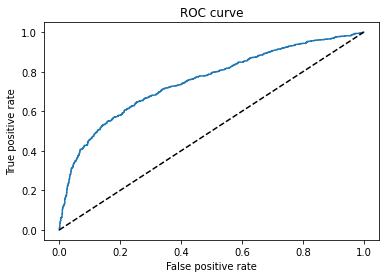

0.7510257510257511


,Feature name,Coefficients
0,Intercept,-0.023247
1,EDUCATION: ['high school'],-0.092502
2,EDUCATION: ['others' 'missing' 'graduate school'],0.015654
3,EDUCATION: ['university'],0.057935
4,PAY_0: ['-1'],-0.376113
5,PAY_0: ['-2'],-0.496623
6,PAY_0: ['0'],-0.729379
7,PAY_0: ['1'],0.064188
8,PAY_0: ['2' '3+'],1.519015
9,PAY_3: ['-2'],-0.373088


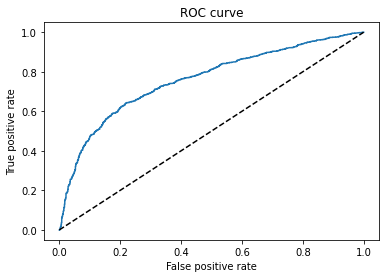

0.7592025


,Feature name,Coefficients
0,Intercept,-0.041818
1,EDUCATION: ['high school'],-0.015061
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.080446
3,EDUCATION: ['university'],0.062160
4,PAY_0: ['-1'],-0.336667
5,PAY_0: ['-2'],-0.400333
6,PAY_0: ['0'],-0.729755
7,PAY_0: ['1'],-0.005765
8,PAY_0: ['2' '3+'],1.439174
9,PAY_3: ['-2'],-0.462893


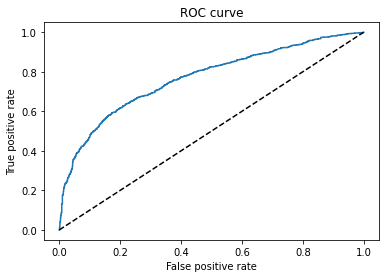

0.7676821332501033


,Feature name,Coefficients
0,Intercept,-0.021708
1,EDUCATION: ['high school'],-0.021386
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.040856
3,EDUCATION: ['university'],0.044496
4,PAY_0: ['-1'],-0.297889
5,PAY_0: ['-2'],-0.577362
6,PAY_0: ['0'],-0.726315
7,PAY_0: ['1'],0.007857
8,PAY_0: ['2' '3+'],1.575964
9,PAY_3: ['-2'],-0.345185


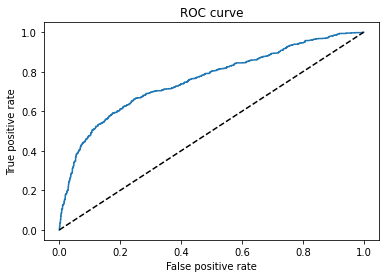

0.7574445325039727


,Feature name,Coefficients
0,Intercept,-0.047461
1,EDUCATION: ['high school'],-0.069437
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.014270
3,EDUCATION: ['university'],0.046186
4,PAY_0: ['-1'],-0.290522
5,PAY_0: ['-2'],-0.521661
6,PAY_0: ['0'],-0.639983
7,PAY_0: ['1'],-0.013459
8,PAY_0: ['2' '3+'],1.428104
9,PAY_3: ['-2'],-0.388197


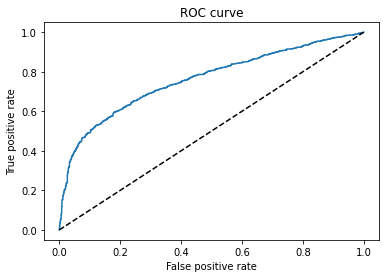

0.7602367644131062
[0.7510257510257511, 0.7592025, 0.7676821332501033, 0.7574445325039727, 0.7602367644131062]
Não está viesado


,Feature name,Coefficients
0,Intercept,0.009957
1,EDUCATION: ['high school'],-0.067659
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.028923
3,EDUCATION: ['university'],0.105293
4,PAY_0: ['-1'],-0.383934
5,PAY_0: ['-2'],-0.473304
6,PAY_0: ['0'],-0.667822
7,PAY_0: ['1'],-0.076897
8,PAY_0: ['2' '3+'],1.610669
9,PAY_3: ['-2'],-0.403143


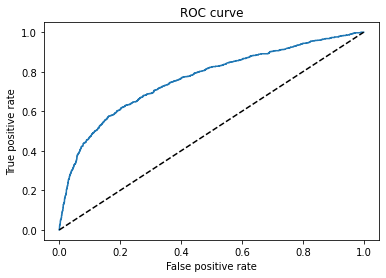

0.7623812219130829


<Figure size 432x288 with 0 Axes>

In [15]:
kfolds = 5
aucs = []
for n in range(kfolds):
    df_des0 = df_des_dummies[df_des_dummies['alvo']==0]
    df_des1 = df_des_dummies[df_des_dummies['alvo']==1]
    df_des0_sample = df_des0.sample(n=5000)
    df_des1_sample = df_des1.sample(n=5000)
    df_nova = pd.concat([df_des0_sample, df_des1_sample], axis=0)
    X_train, X_test, y_train, y_test=train_test_split(df_nova.drop('alvo', axis=1), df_nova['alvo'], test_size=0.2)
    reg = LogisticRegression()
    reg.fit(X_train, y_train)
    feature_name = X_train.columns.values
    summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
    summary_table['Coefficients'] = np.transpose(reg.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
    summary_table = summary_table.sort_index()
    display(summary_table)
    y_hat_test = reg.predict(X_test)
    y_hat_test_proba = reg.predict_proba(X_test)
    y_hat_test_proba = y_hat_test_proba[: ][: , 1]
    loan_data_targets_test_temp = y_test
    loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
    df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
    df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
    fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    plt.clf()
    AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
    print(AUROC)
    aucs.append(AUROC)
print(aucs)
if max(aucs)-min(aucs) <= 0.03:
    print('Não está viesado')
    df_des0 = df_des_dummies[df_des_dummies['alvo']==0]
    df_des1 = df_des_dummies[df_des_dummies['alvo']==1]
    df_des0_sample = df_des0.sample(n=5000)
    df_des1_sample = df_des1.sample(n=5000)
    df_nova = pd.concat([df_des0_sample, df_des1_sample], axis=0)
    X_train = df_nova.drop(columns='alvo')
    X_test = df_oot_dummies.drop(columns='alvo')
    y_train = df_nova['alvo']
    y_test = df_oot_dummies['alvo']
    reg = LogisticRegression()
    reg.fit(X_train, y_train)
    feature_name = X_train.columns.values
    summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
    summary_table['Coefficients'] = np.transpose(reg.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
    summary_table = summary_table.sort_index()
    display(summary_table)
    y_hat_test = reg.predict(X_test)
    y_hat_test_proba = reg.predict_proba(X_test)
    y_hat_test_proba = y_hat_test_proba[: ][: , 1]
    loan_data_targets_test_temp = y_test
    loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
    df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
    df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
    fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    plt.clf()
    AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
    print(AUROC)
    
    
else:
    print('Está viesado')

In [16]:
pd.options.display.max_rows=94
summary_table

,Feature name,Coefficients
0,Intercept,0.009957
1,EDUCATION: ['high school'],-0.067659
2,EDUCATION: ['others' 'missing' 'graduate school'],-0.028923
3,EDUCATION: ['university'],0.105293
4,PAY_0: ['-1'],-0.383934
5,PAY_0: ['-2'],-0.473304
6,PAY_0: ['0'],-0.667822
7,PAY_0: ['1'],-0.076897
8,PAY_0: ['2' '3+'],1.610669
9,PAY_3: ['-2'],-0.403143


In [ ]:
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(0 , 45000)), 0, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(45000, 75000)), 1, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(75000, 125000)), 2, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(125000, 165000)), 3, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(165000, 205000)), 4, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(205000, 245000)), 5, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'].isin(range(245000, 365000)), 6, df['LIMIT_BAL'])
# df['LIMIT_BAL'] = np.where(df['LIMIT_BAL'] >= 365000, 7, df['LIMIT_BAL'])
# df['AGE_REC'] = np.where(df['AGE_REC']<0.03, 0, 1)
# df['BILL_AMT1_POW'] = np.where(df['BILL_AMT1_POW']<188.78, 0, df['BILL_AMT1_POW'])
# df['BILL_AMT1_POW'] = np.where(df['BILL_AMT1_POW'] >= 188.78, 1, df['BILL_AMT1_POW'])
# df['BILL_AMT1_POW'] = np.where(df['BILL_AMT1_POW'].isna(), 3, df['BILL_AMT1_POW'])
# df['BILL_AMT2_POW'] = np.where(df['BILL_AMT2_POW']<187.13, 0, df['BILL_AMT2_POW'])
# df['BILL_AMT2_POW'] = np.where(df['BILL_AMT2_POW'] >= 187.13, 1, df['BILL_AMT2_POW'])
# df['BILL_AMT2_POW'] = np.where(df['BILL_AMT2_POW'].isna(), 3, df['BILL_AMT2_POW'])
# df['BILL_AMT3_POW'] = np.where(df['BILL_AMT3_POW']<56, 0, df['BILL_AMT3_POW'])
# df['BILL_AMT3_POW'] = np.where((df['BILL_AMT3_POW']>=56) & (df['BILL_AMT3_POW']< 225), 1, df['BILL_AMT3_POW'])
# df['BILL_AMT3_POW'] = np.where(df['BILL_AMT3_POW'] >= 225, 2, df['BILL_AMT3_POW'])
# df['BILL_AMT3_POW'] = np.where(df['BILL_AMT3_POW'].isna(), 3, df['BILL_AMT3_POW'])
# df['BILL_AMT4_POW'] = np.where(df['BILL_AMT4_POW']<50, 0, df['BILL_AMT4_POW'])
# df['BILL_AMT4_POW'] = np.where((df['BILL_AMT4_POW']>=50) & (df['BILL_AMT4_POW']< 188), 1, df['BILL_AMT4_POW'])
# df['BILL_AMT4_POW'] = np.where(df['BILL_AMT4_POW'] >= 188, 2, df['BILL_AMT4_POW'])
# df['BILL_AMT4_POW'] = np.where(df['BILL_AMT4_POW'].isna(), 3, df['BILL_AMT4_POW'])
# df['BILL_AMT5_POW'] = np.where(df['BILL_AMT5_POW']<50, 0, df['BILL_AMT5_POW'])
# df['BILL_AMT5_POW'] = np.where((df['BILL_AMT5_POW']>=50) & (df['BILL_AMT5_POW']< 226), 1, df['BILL_AMT5_POW'])
# df['BILL_AMT5_POW'] = np.where(df['BILL_AMT5_POW'] >= 226, 2, df['BILL_AMT5_POW'])
# df['BILL_AMT5_POW'] = np.where(df['BILL_AMT5_POW'].isna(), 3, df['BILL_AMT5_POW'])
# df['BILL_AMT6_POW'] = np.where(df['BILL_AMT6_POW']< 21, 0, df['BILL_AMT6_POW'])
# df['BILL_AMT6_POW'] = np.where((df['BILL_AMT6_POW']>=21) & (df['BILL_AMT6_POW']< 226), 1, df['BILL_AMT6_POW'])
# df['BILL_AMT6_POW'] = np.where(df['BILL_AMT6_POW'] >= 226, 2, df['BILL_AMT6_POW'])
# df['BILL_AMT6_POW'] = np.where(df['BILL_AMT6_POW'].isna(), 3, df['BILL_AMT6_POW'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1']< 21, 0, df['PAY_AMT1'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1'].isin(range(21, 1604)), 1, df['PAY_AMT1'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1'].isin(range(1604, 2000)), 2, df['PAY_AMT1'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1'].isin(range(2000, 3700)), 3, df['PAY_AMT1'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1'].isin(range(3700, 7821)), 4, df['PAY_AMT1'])
# df['PAY_AMT1'] = np.where(df['PAY_AMT1'] >= 7821, 5, df['PAY_AMT1'])
# df['PAY_AMT2'] = np.where(df['PAY_AMT2']< 91, 0, df['PAY_AMT2'])
# df['PAY_AMT2'] = np.where(df['PAY_AMT2'].isin(range(91, 1602)), 1, df['PAY_AMT2'])
# df['PAY_AMT2'] = np.where(df['PAY_AMT2'].isin(range(1602, 3720)), 2, df['PAY_AMT2'])
# df['PAY_AMT2'] = np.where(df['PAY_AMT2'].isin(range(3720, 9903)), 3, df['PAY_AMT2'])
# df['PAY_AMT2'] = np.where(df['PAY_AMT2'] >= 9903, 4, df['PAY_AMT2'])
# df['PAY_AMT3'] = np.where(df['PAY_AMT3']< 2, 0, df['PAY_AMT3'])
# df['PAY_AMT3'] = np.where(df['PAY_AMT3'].isin(range(2, 1600)), 1, df['PAY_AMT3'])
# df['PAY_AMT3'] = np.where(df['PAY_AMT3'].isin(range(1600, 4641)), 2, df['PAY_AMT3'])
# df['PAY_AMT3'] = np.where(df['PAY_AMT3'] >= 4641, 3, df['PAY_AMT3'])
# df['PAY_AMT4'] = np.where(df['PAY_AMT4']< 1, 0, df['PAY_AMT4'])
# df['PAY_AMT4'] = np.where(df['PAY_AMT4'].isin(range(1, 1001)), 1, df['PAY_AMT4'])
# df['PAY_AMT4'] = np.where(df['PAY_AMT4'].isin(range(1001, 2052)), 2, df['PAY_AMT4'])
# df['PAY_AMT4'] = np.where(df['PAY_AMT4'].isin(range(2052, 4327)), 3, df['PAY_AMT4'])
# df['PAY_AMT4'] = np.where(df['PAY_AMT4'] >= 4327, 4, df['PAY_AMT4'])
# df['PAY_AMT5'] = np.where(df['PAY_AMT5']< 715, 0, df['PAY_AMT5'])
# df['PAY_AMT5'] = np.where(df['PAY_AMT5'].isin(range(715, 2927)), 1, df['PAY_AMT5'])
# df['PAY_AMT5'] = np.where(df['PAY_AMT5'] >= 2927, 2, df['PAY_AMT5'])
# df['PAY_AMT6'] = np.where(df['PAY_AMT6']< 2, 0, df['PAY_AMT6'])
# df['PAY_AMT6'] = np.where(df['PAY_AMT6'].isin(range(2, 1501)), 1, df['PAY_AMT6'])
# df['PAY_AMT6'] = np.where(df['PAY_AMT6'].isin(range(1501, 4058)), 2, df['PAY_AMT6'])
# df['PAY_AMT6'] = np.where(df['PAY_AMT6'] >= 4058, 3, df['PAY_AMT6'])

In [ ]:
# var_selecionadas = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE_REC', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1_POW', 'BILL_AMT2_POW', 'BILL_AMT3_POW', 'BILL_AMT4_POW',
#                     'BILL_AMT5_POW', 'BILL_AMT6_POW', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# df[var_selecionadas].corr()

In [ ]:
# def IV(df_X_prepr, variaveis, y_prepr, df_name):
#     df_y_prepr = df_X_prepr[y_prepr]
#     todosivs=[]
    
#     for discrete_variable_name in variaveis:
#         df1=pd.concat([df_X_prepr[discrete_variable_name], df_y_prepr], axis=1)
#         df1=pd.concat([df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count(), 
#                        df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()], axis=1)
#         df1=df1.iloc[:, [0, 1, 3]]
#         df1.columns=[df1.columns.values[0], 'n_obs', 'prop_bad']
#         df1['prop_n_obs']=df1['n_obs']/df1['n_obs'].sum()
#         df1['n_bad']=df1['prop_bad']*df1['n_obs']
#         df1['n_good']=(1-df1['prop_bad'])*df1['n_obs']
#         df1['prop_n_bad']=df1['n_bad']/df1['n_bad'].sum()
#         df1['prop_n_good']=df1['n_good']/df1['n_good'].sum()
#         df1['WoE']=np.log(df1['prop_n_good']/df1['prop_n_bad'])
#         df1=df1.sort_values(['WoE'])
#         df1=df1.reset_index(drop=True)
#         df1['diff_prop_bad']=df1['prop_bad'].diff().abs()
#         df1['diff_WoE']=df1['WoE'].diff().abs()
#         df1['IV']=(df1['prop_n_bad']-df1['prop_n_good'])*df1['WoE']
#         df1['IV']=df1['IV'].sum()       
#         todosivs.append(df1['IV'].unique()[0])

#     count=0
#     for i in todosivs:
#         if abs(i)>=0.3:
#             count+=1
#     porciv = round(100*count/len(todosivs), 2)
#     txt=f'{porciv}% das variáveis da {df_name} possuem IV maior que 30% ({count} de {len(todosivs)})'
#     print(txt)
#     print()
#     tabivs = pd.DataFrame()
#     tabivs['Variável'] = variaveis
#     tabivs['IV'] = todosivs
#     display(tabivs)

# IV(df, var_selecionadas, 'alvo', 'df_selecionadas')


In [216]:
# var_selecionadas2 = ['LIMIT_BAL', 'SEX','EDUCATION','MARRIAGE', 'AGE_REC', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1_POW', 'BILL_AMT3_POW',
#                     'BILL_AMT6_POW', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [8]:
# df_des_dummies = pd.DataFrame()
# df_oot_dummies = pd.DataFrame()
# for col in var_selecionadas2:
#     df_provs = pd.get_dummies(df_des[col], prefix=col, prefix_sep=': ')
#     df_provsoot = pd.get_dummies(df_oot[col], prefix=col, prefix_sep=': ')
#     df_des_dummies=pd.concat([df_des_dummies, df_provs], axis=1)
#     df_oot_dummies=pd.concat([df_oot_dummies, df_provsoot], axis=1)

    
# df_des_dummies=pd.concat([df_des_dummies, df_des['alvo']], axis=1)
# print(df_des_dummies.shape)
# df_oot_dummies=pd.concat([df_oot_dummies, df_oot['alvo']], axis=1)
# print(df_oot_dummies.shape)

## Análise betas:

- quanto maior o valor do empréstimo, maior a chance de ele não ser pago (beta mais negativo). Faz sentido.

- mulheres têm beta mais negativo, ou seja, são bem mais inadimplentes. Isso é estranho.

- quanto maior o nível de educação, maior a chance de pagar. Faz sentido.

- Marriage ta meio estranho. O que deveria ser?

- Quanto maior a idade, menor a transformação recíproca e então maior a chance de pagar. Faz sentido.

- Não há legenda para as categorias 0 e -2 dos pays. Além disso, na maioria das vezes, as categorias de atraso não seguem um padrão lógico ascendente ou descendente.


# Não precisa rodar sempre

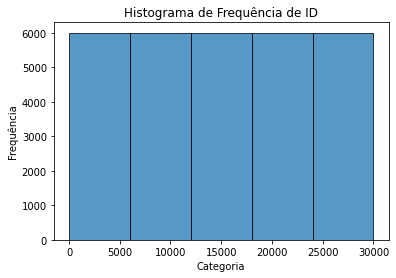

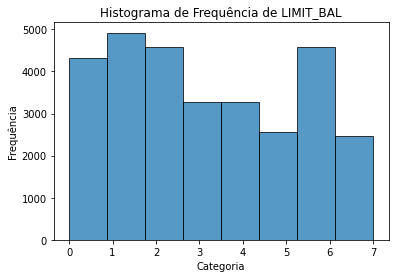

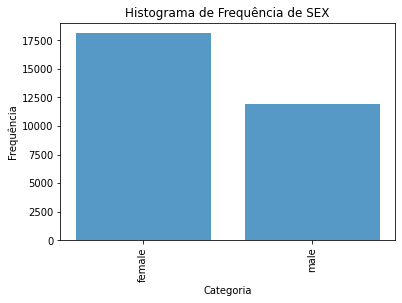

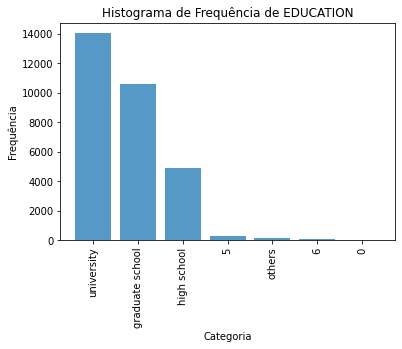

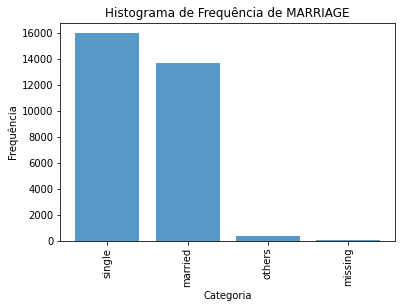

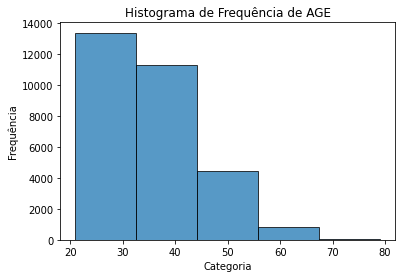

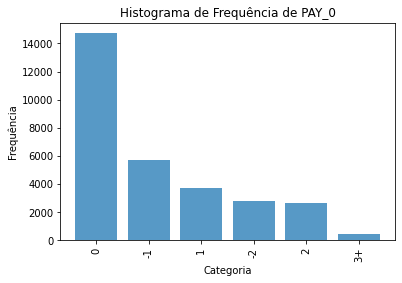

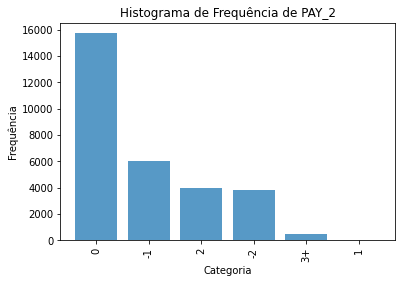

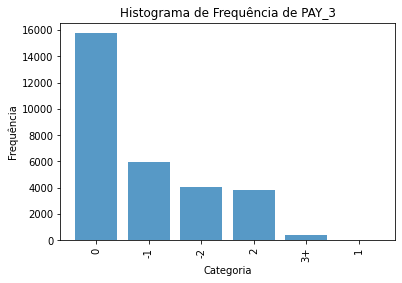

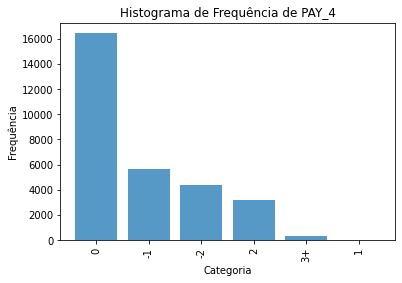

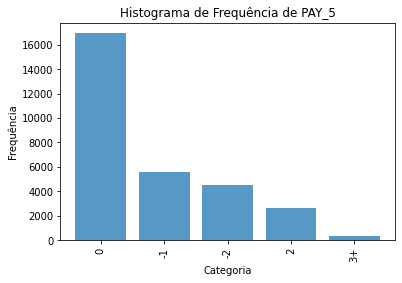

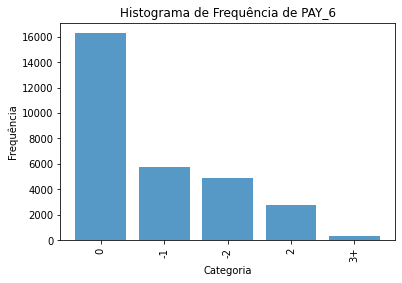

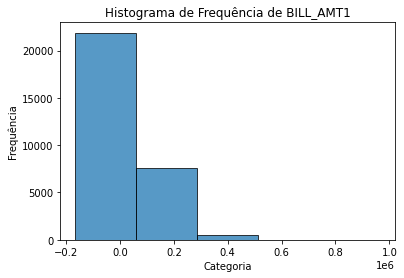

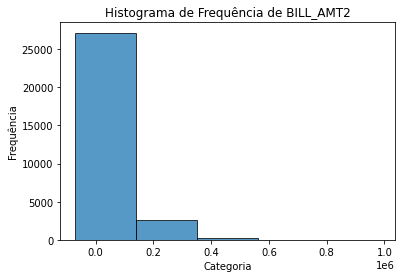

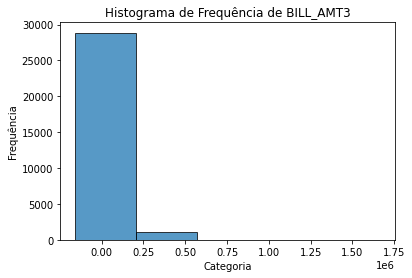

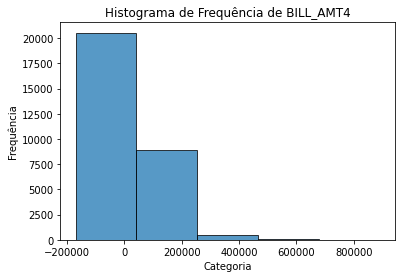

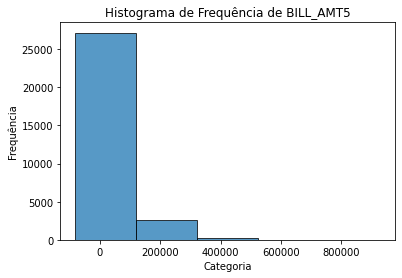

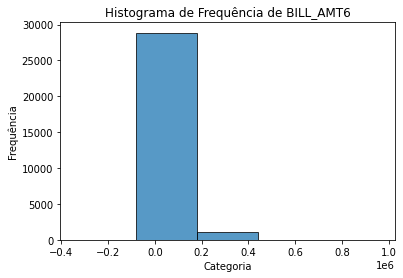

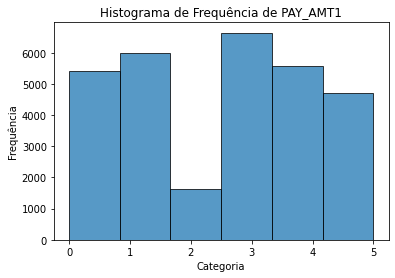

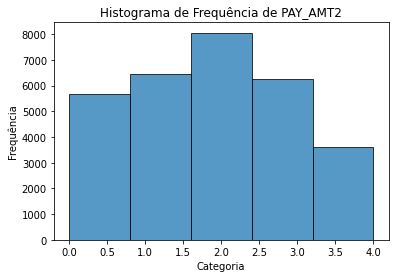

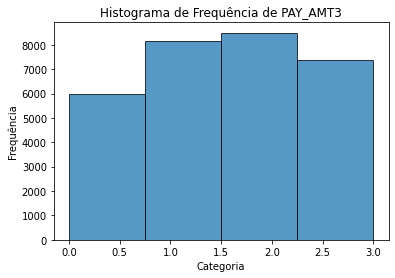

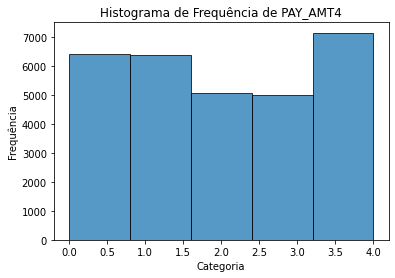

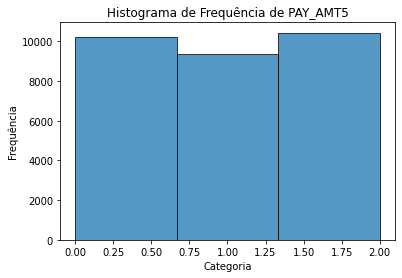

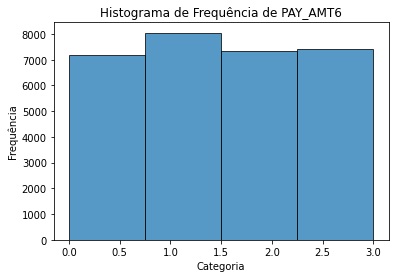

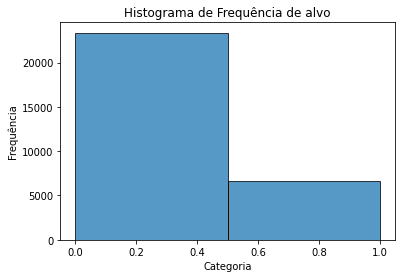

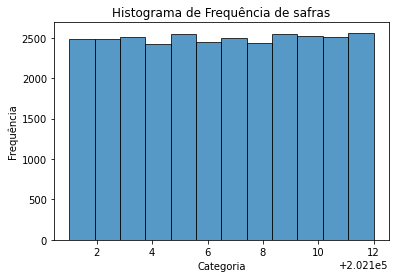

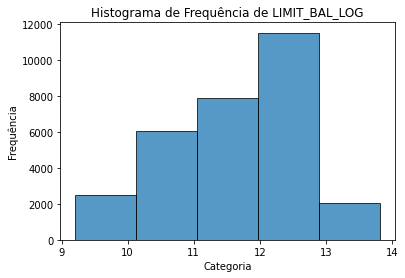

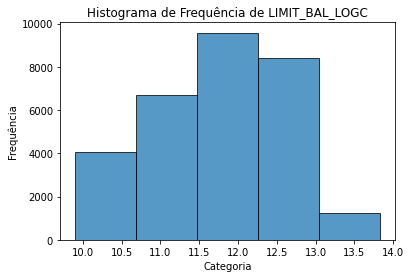

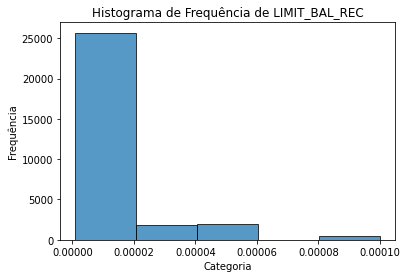

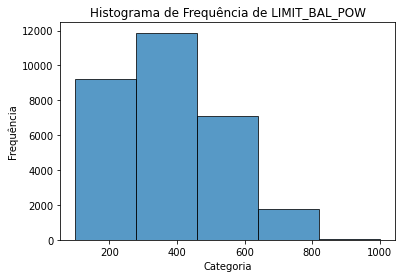

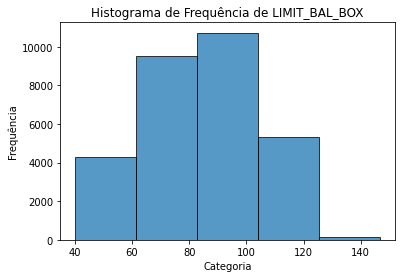

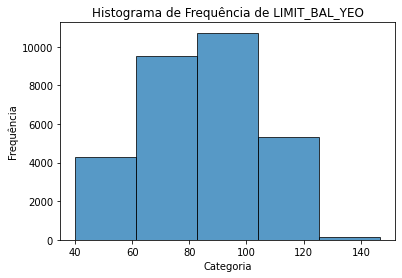

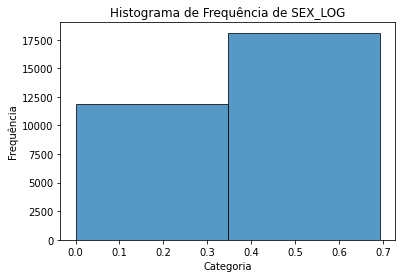

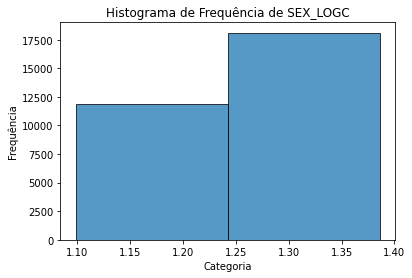

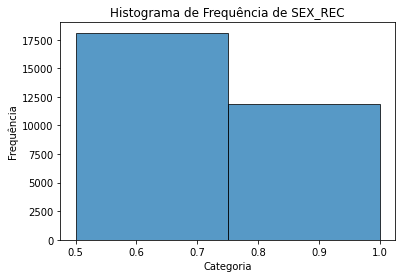

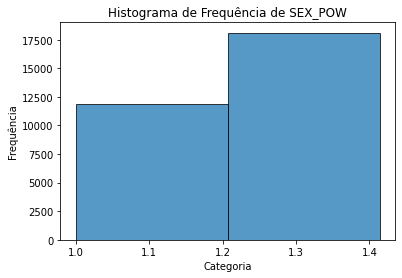

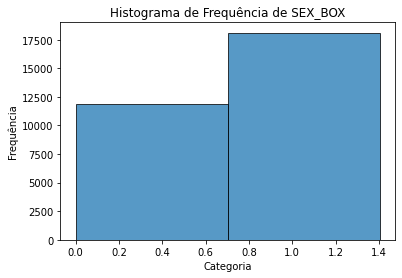

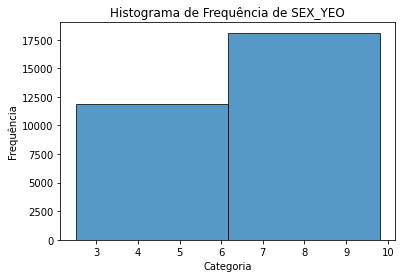

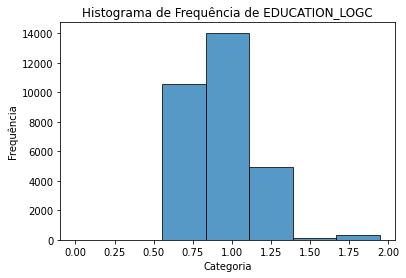

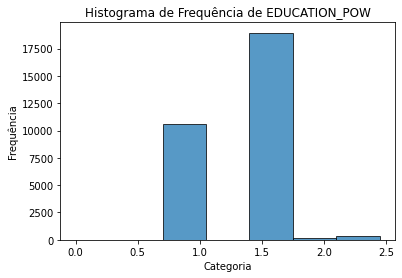

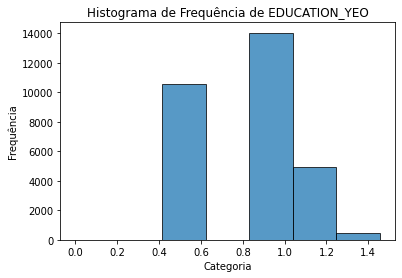

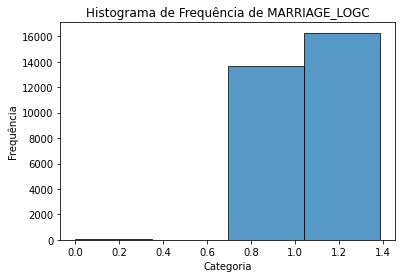

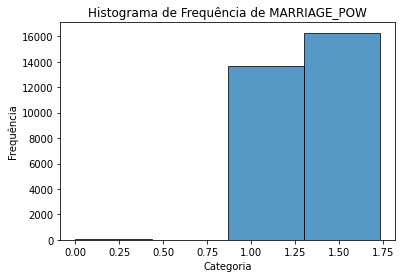

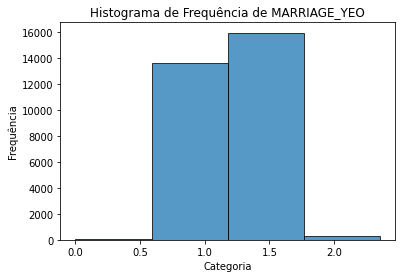

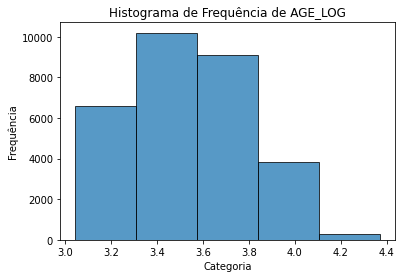

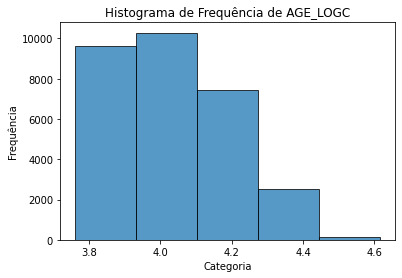

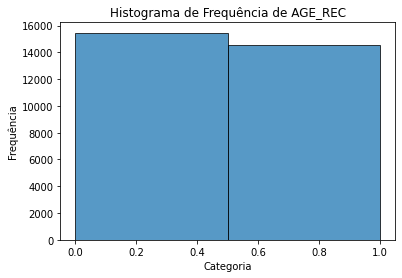

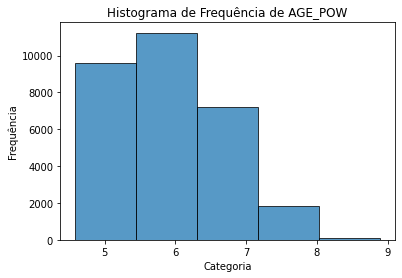

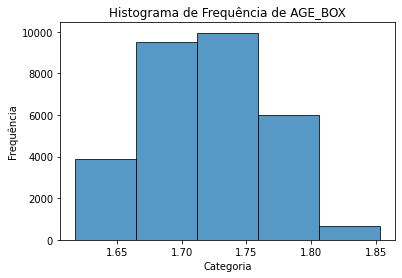

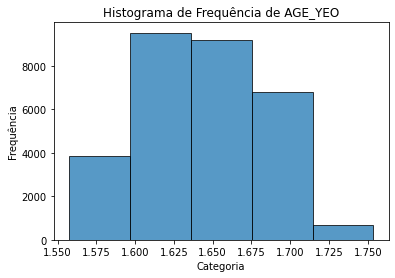

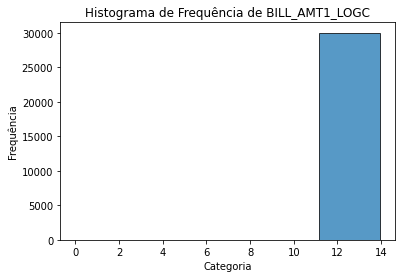

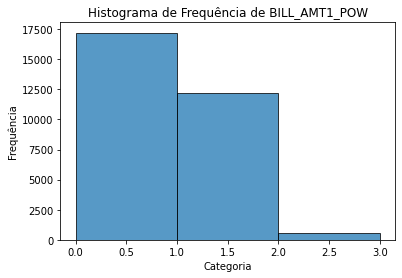

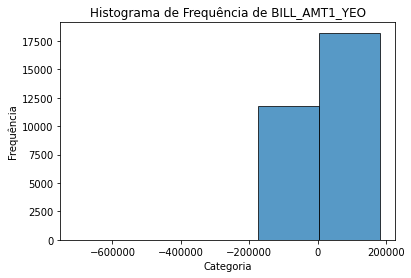

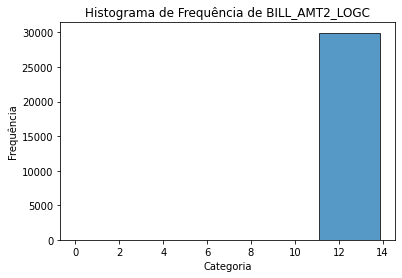

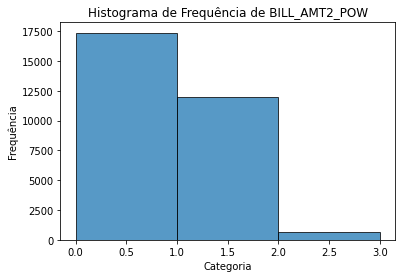

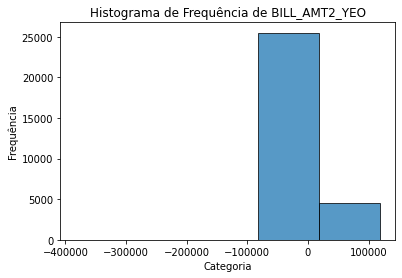

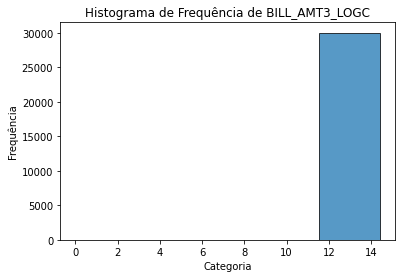

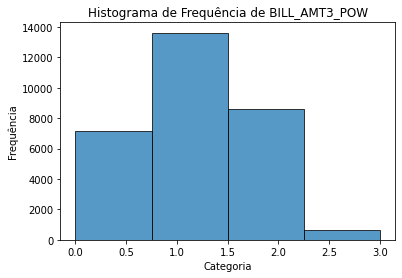

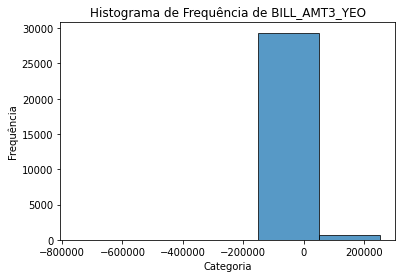

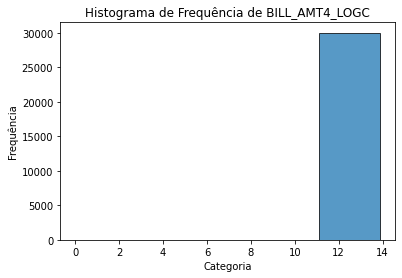

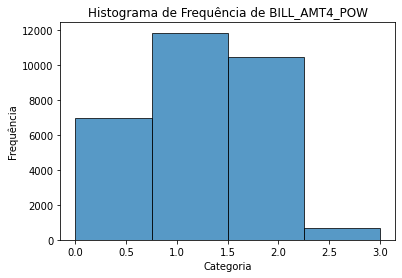

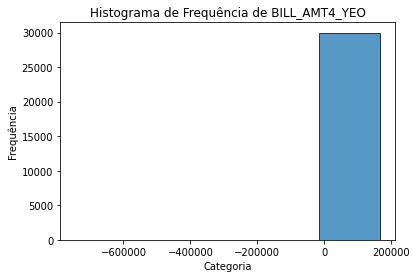

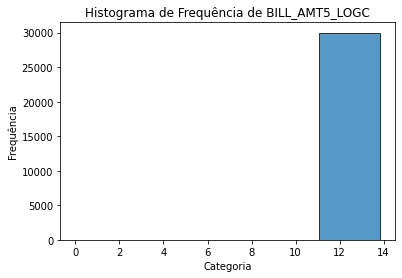

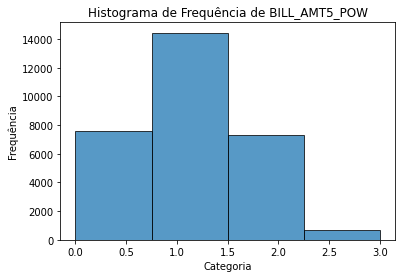

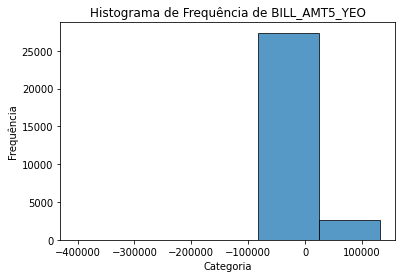

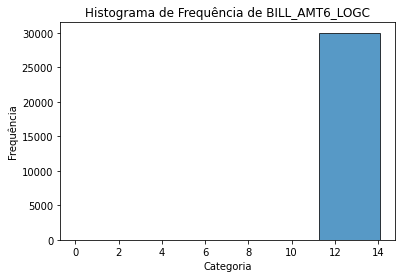

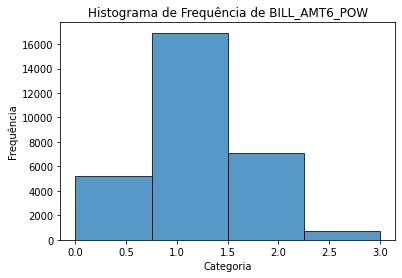

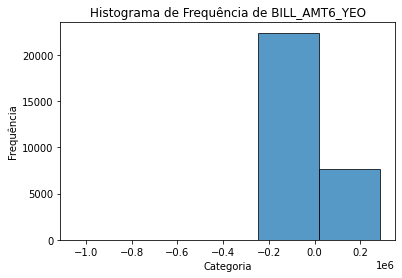

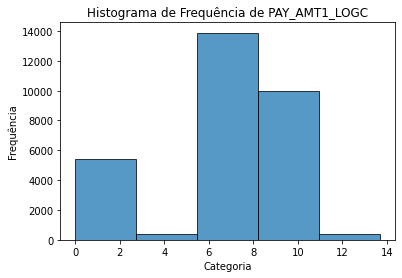

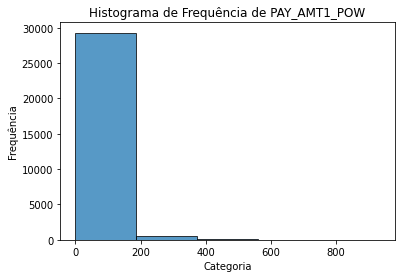

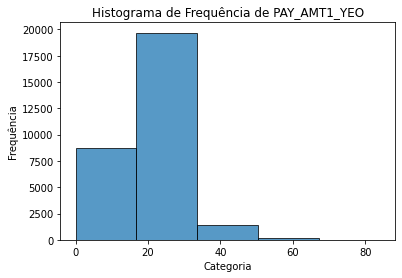

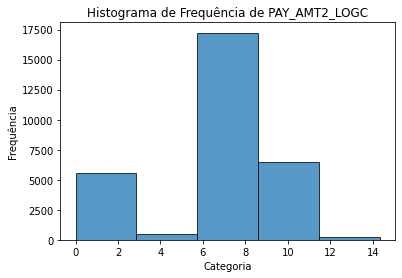

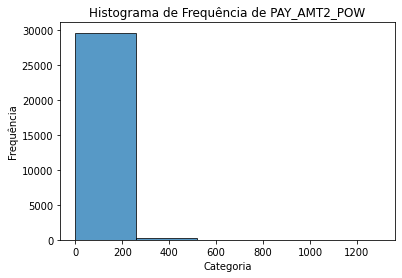

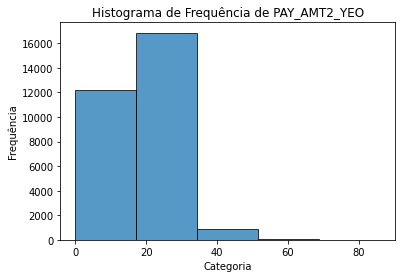

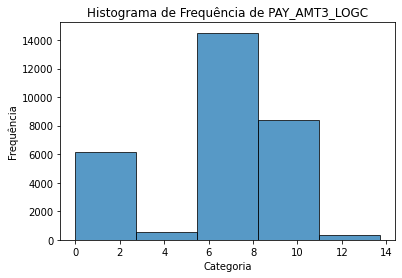

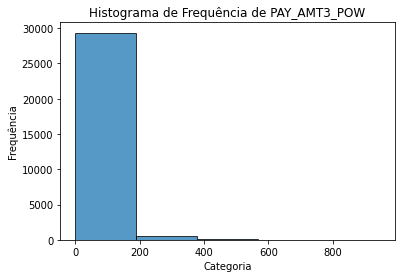

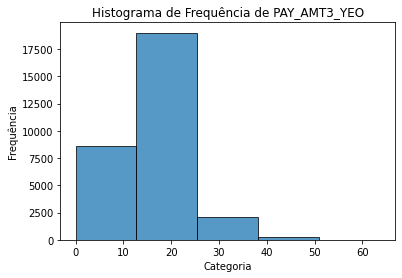

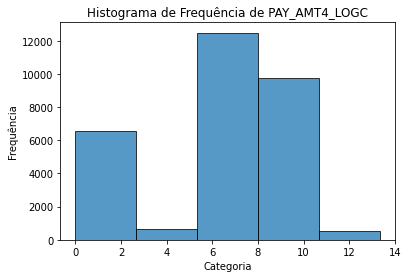

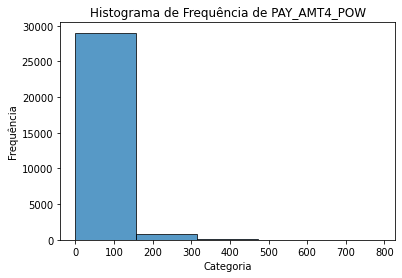

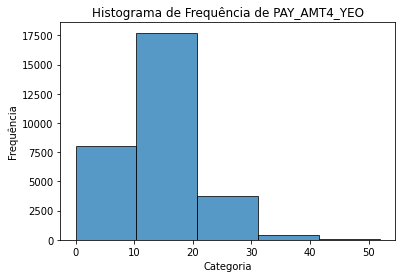

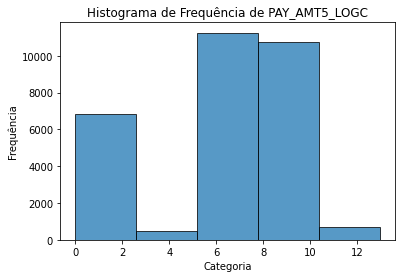

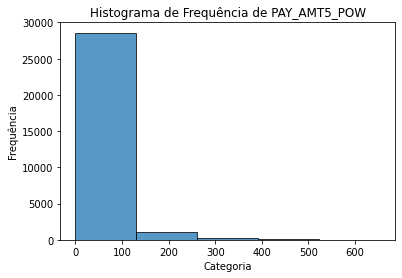

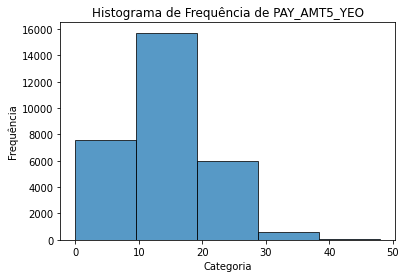

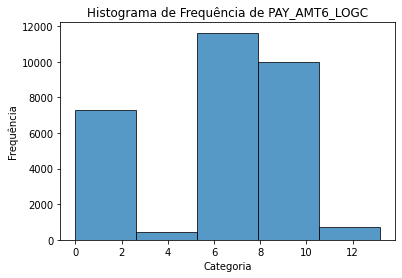

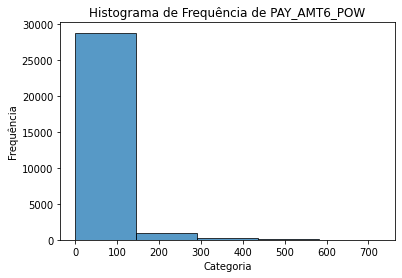

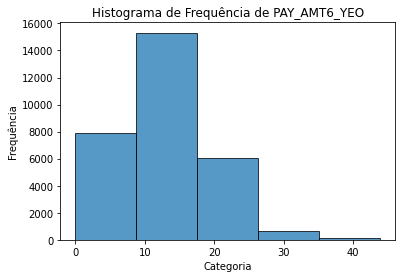

<Figure size 432x288 with 0 Axes>

In [116]:
for col in df.columns.values:
    dados = df[col]
    if dados.dtype == 'object':
        counts = dados.value_counts()
        n = len(counts)
        plt.bar(counts.index.astype(str), counts.values, alpha=0.75)
        plt.xticks(rotation=90)
    else:
        if len(df[col].unique()) > 12:
            n = '5'
        else:
            n = str(len(df[col].unique()))
        plt.hist(dados, bins=int(n), edgecolor='black', alpha=0.75)
    plt.xlabel('Categoria')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Frequência de {col}')
    plt.show()
    plt.clf()

In [86]:
df.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,alvo,safras,LIMIT_BAL_LOG,LIMIT_BAL_LOGC,LIMIT_BAL_REC,LIMIT_BAL_POW,LIMIT_BAL_BOX,LIMIT_BAL_YEO,SEX_LOG,SEX_LOGC,SEX_REC,SEX_POW,SEX_BOX,SEX_YEO,EDUCATION_LOGC,EDUCATION_POW,EDUCATION_YEO,MARRIAGE_LOGC,MARRIAGE_POW,MARRIAGE_YEO,AGE_LOG,AGE_LOGC,AGE_REC,AGE_POW,AGE_BOX,AGE_YEO,BILL_AMT1_LOGC,BILL_AMT1_POW,BILL_AMT1_YEO,BILL_AMT2_LOGC,BILL_AMT2_POW,BILL_AMT2_YEO,BILL_AMT3_LOGC,BILL_AMT3_POW,BILL_AMT3_YEO,BILL_AMT4_LOGC,BILL_AMT4_POW,BILL_AMT4_YEO,BILL_AMT5_LOGC,BILL_AMT5_POW,BILL_AMT5_YEO,BILL_AMT6_LOGC,BILL_AMT6_POW,BILL_AMT6_YEO,PAY_AMT1_LOGC,PAY_AMT1_POW,PAY_AMT1_YEO,PAY_AMT2_LOGC,PAY_AMT2_POW,PAY_AMT2_YEO,PAY_AMT3_LOGC,PAY_AMT3_POW,PAY_AMT3_YEO,PAY_AMT4_LOGC,PAY_AMT4_POW,PAY_AMT4_YEO,PAY_AMT5_LOGC,PAY_AMT5_POW,PAY_AMT5_YEO,PAY_AMT6_LOGC,PAY_AMT6_POW,PAY_AMT6_YEO
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,3.157200,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,2.505167,1.854700,1.576200,2.003700,1.007167,1.498900,0.221200,202106.550533,11.663002,11.785156,0.000014,377.144346,83.405098,83.400008,0.418476,1.272296,0.698133,1.250075,0.848067,6.915456,1.012193,1.331331,0.858571,0.915124,1.226499,1.315957,3.536971,4.039265,0.484467,5.908945,1.719808,1.642508,12.244965,0.465667,12894.250977,11.569295,0.465567,8576.832728,12.186354,1.091200,10598.194537,12.237081,1.160600,10838.624402,11.626813,1.036067,8141.256866,12.833511,1.108600,1.436996e+04,6.630003,55.100810,18.570387,6.562652,54.560198,17.169297,6.283188,50.253561,14.810331,6.077716,47.366861,13.194731,6.032192,47.216316,13.069190,5.932831,47.506981,11.983179
std,8660.398374,2.285942,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,1.746084,1.279079,1.065566,1.478972,0.829581,1.105911,0.415062,3.462588,0.941135,0.827076,0.000017,158.894010,20.609974,20.608018,0.339039,0.140714,0.244565,0.202604,0.687082,3.574343,0.267288,0.284066,0.193565,0.210355,0.218104,0.398438,0.251541,0.155066,0.499767,0.754909,0.047265,0.039494,0.277028,0.605668,17369.199886,0.448410,0.618569,11399.069816,0.273141,0.776811,14623.407089,0.248672,0.804008,15301.797459,0.375703,0.763316,11545.884922,0.153757,0.701966,2.190361e+04,3.250304,51.259817,10.768919,3.278754,54.262754,10.067875,3.349722,51.964903,9.086266,3.396598,50.818731,8.361448,3.443995,50.696083,8.394088,3.528092,54.393823,7.905514
min,1.000000,0.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,202101.000000,9.210340,9.903538,0.000001,100.000000,40.146711,40.146009,0.000000,1.098612,0.500000,1.000000,0.000000,2.503636,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,3.044522,3.761200,0.000000,4.582576,1.617725,1.557380,0.000000,0.000000,-707758.850685,0.000000,0.000000,-383594.196250,0.000000,0.000000,-755807.577502,0.000000,0.000000,-743715.95613

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 86 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              30000 non-null  int64  
 1   LIMIT_BAL       30000 non-null  int64  
 2   SEX             30000 non-null  object 
 3   EDUCATION       30000 non-null  object 
 4   MARRIAGE        30000 non-null  object 
 5   AGE             30000 non-null  int64  
 6   PAY_0           30000 non-null  object 
 7   PAY_2           30000 non-null  object 
 8   PAY_3           30000 non-null  object 
 9   PAY_4           30000 non-null  object 
 10  PAY_5           30000 non-null  object 
 11  PAY_6           30000 non-null  object 
 12  BILL_AMT1       30000 non-null  int64  
 13  BILL_AMT2       30000 non-null  int64  
 14  BILL_AMT3       30000 non-null  int64  
 15  BILL_AMT4       30000 non-null  int64  
 16  BILL_AMT5       30000 non-null  int64  
 17  BILL_AMT6       30000 non-null 

In [15]:
X_oot_transf.isna().sum()

ID                0
LIMIT_BAL         0
SEX               0
EDUCATION         0
MARRIAGE          0
AGE               0
PAY_0             0
PAY_2             0
PAY_3             0
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1         0
BILL_AMT2         0
BILL_AMT3         0
BILL_AMT4         0
BILL_AMT5         0
BILL_AMT6         0
PAY_AMT1          0
PAY_AMT2          0
PAY_AMT3          0
PAY_AMT4          0
PAY_AMT5          0
PAY_AMT6          0
safras            0
LIMIT_BAL_LOG     0
LIMIT_BAL_LOGC    0
LIMIT_BAL_REC     0
LIMIT_BAL_POW     0
LIMIT_BAL_BOX     0
LIMIT_BAL_YEO     0
SEX_LOG           0
SEX_LOGC          0
SEX_REC           0
SEX_POW           0
SEX_BOX           0
SEX_YEO           0
EDUCATION_LOGC    0
EDUCATION_POW     0
EDUCATION_YEO     0
MARRIAGE_LOGC     0
MARRIAGE_POW      0
MARRIAGE_YEO      0
AGE_LOG           0
AGE_LOGC          0
AGE_REC           0
AGE_POW           0
AGE_BOX           0
AGE_YEO           0
BILL_AMT1_LOGC    0


In [89]:
for col in df_des.columns.values:
    print(col, df_des[col].unique(), '---',  len(df_des[col].unique()))

ID [   10    20    31 ... 29993 29995 29998] --- 24812
LIMIT_BAL [0 4 5 6 3 7 1 2] --- 8
SEX [1 2] --- 2
EDUCATION [3 1 2 5 4 6 0] --- 7
MARRIAGE [2 1 3 0] --- 4
AGE [35 29 27 32 38 31 40 36 24 23 60 30 45 37 22 34 25 44 49 53 42 48 28 47
 56 26 43 41 33 58 57 55 46 54 21 52 50 39 65 67 51 61 62 66 59 63 64 75
 72 69 70 68 71 79 74 73] --- 56
PAY_0 ['-2' '1' '-1' '0' '2' '3+'] --- 6
PAY_2 ['-2' '-1' '0' '2' '3+' '1'] --- 6
PAY_3 ['-2' '-1' '0' '2' '3+' '1'] --- 6
PAY_4 ['-2' '-1' '0' '2' '3+' '1'] --- 6
PAY_5 ['-1' '-2' '0' '3+' '2'] --- 5
PAY_6 ['-1' '-2' '0' '3+' '2'] --- 5
BILL_AMT1 [    0 16646  3048 ...  1822  8802 72557] --- 19269
BILL_AMT2 [    0 17265  5550 ...  6813 44638  3356] --- 18948
BILL_AMT3 [    0 13266 23337 ...  2712 79384  2758] --- 18644
BILL_AMT4 [    0 15339  4291 ...  2882 77519 20878] --- 18296
BILL_AMT5 [13007     0 14307 ... 19971  9235 82607] --- 17831
BILL_AMT6 [13912     0 36923 ... 47417 81158 19357] --- 17460
PAY_AMT1 [0 5 4 1 3 2] --- 6
PAY_AMT2 [0 4 2 

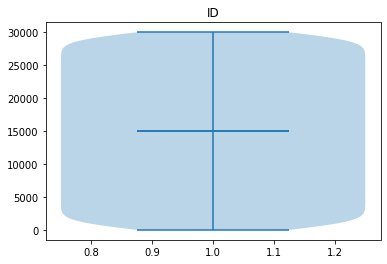

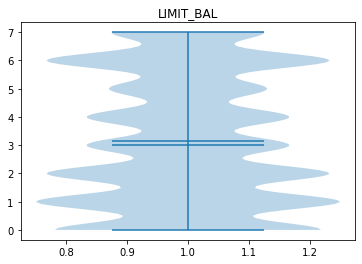

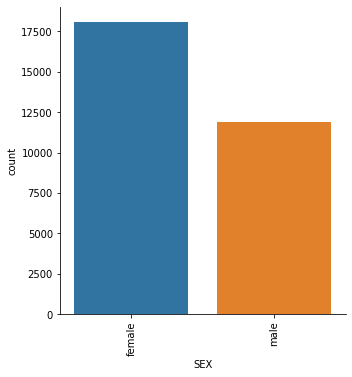

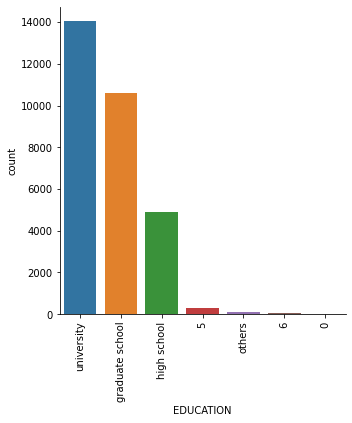

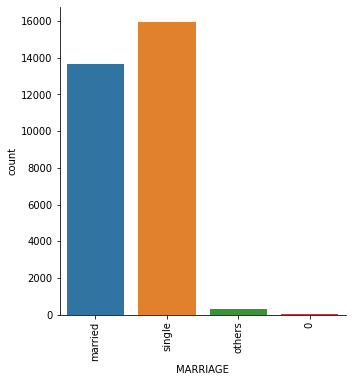

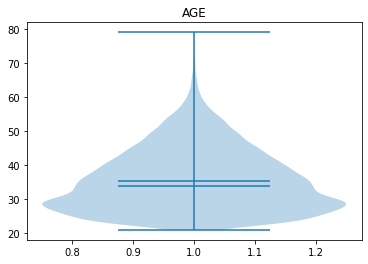

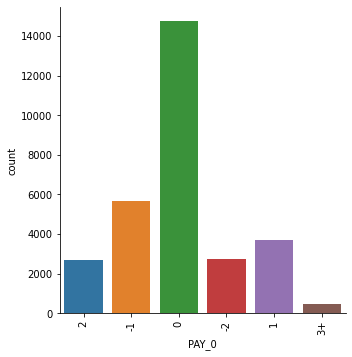

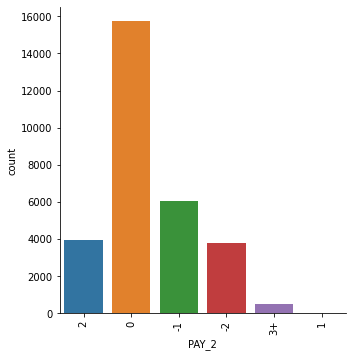

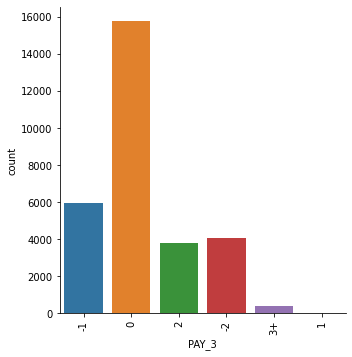

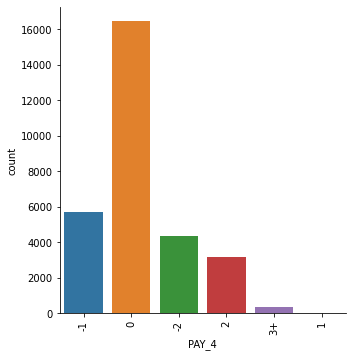

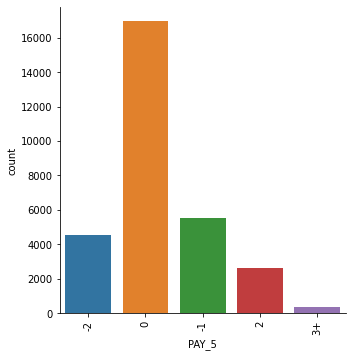

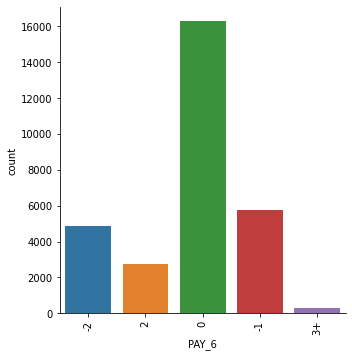

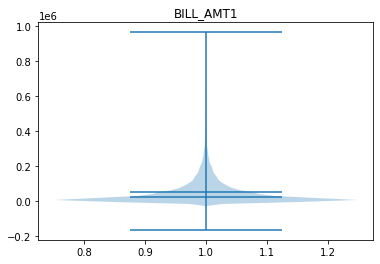

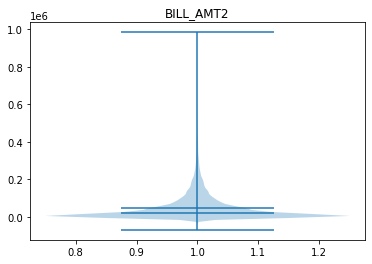

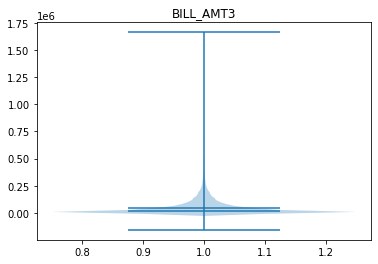

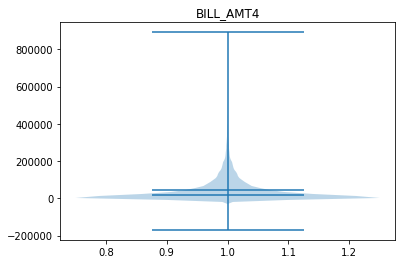

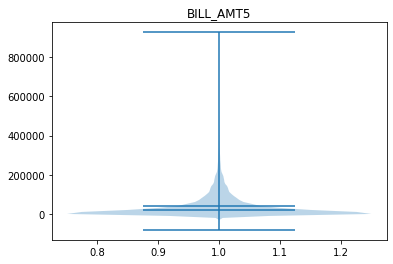

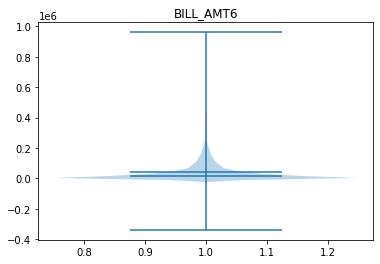

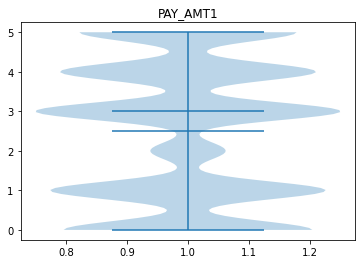

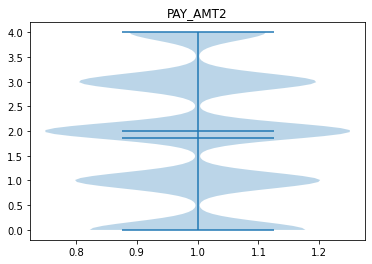

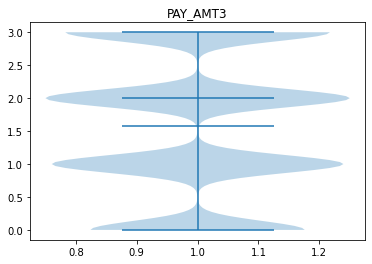

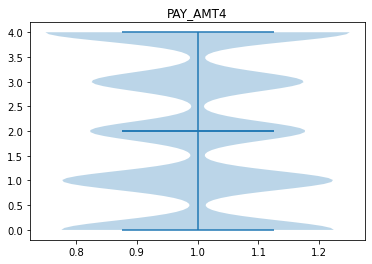

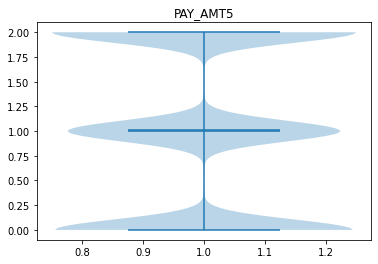

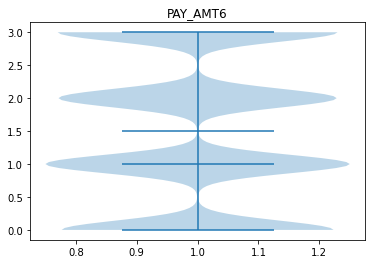

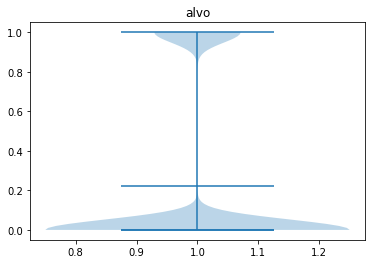

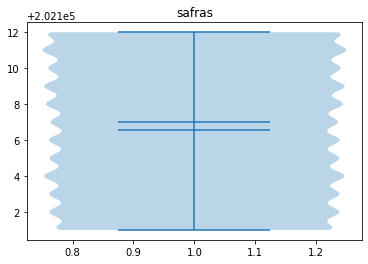

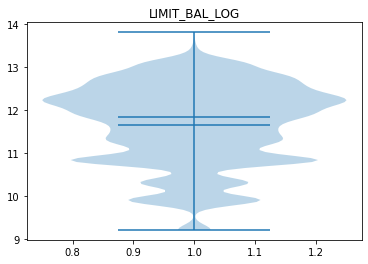

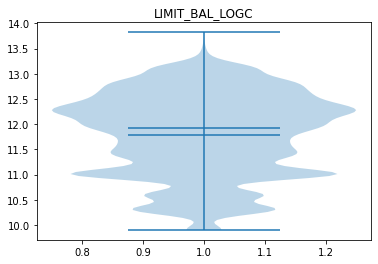

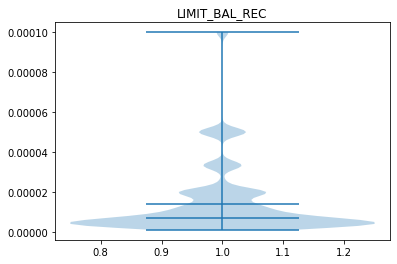

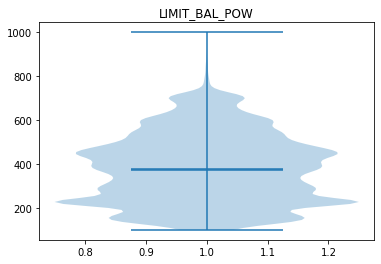

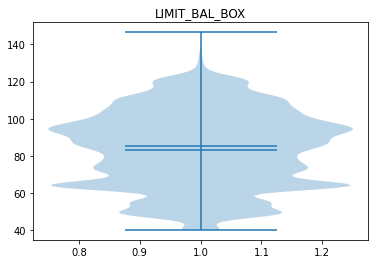

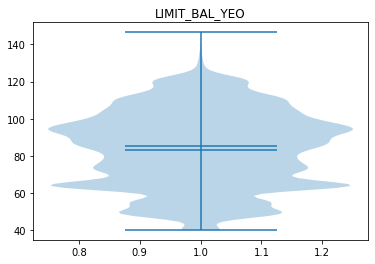

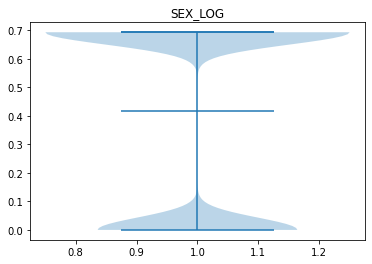

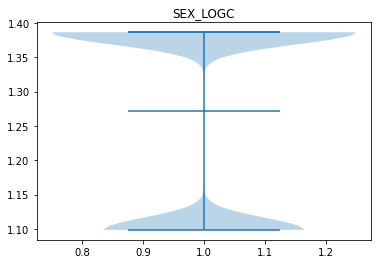

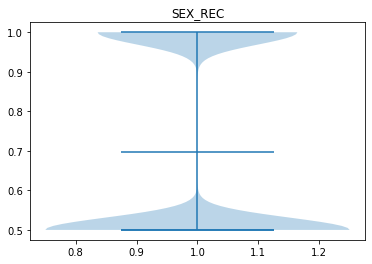

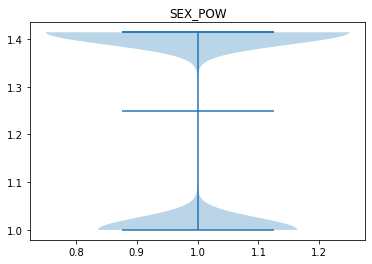

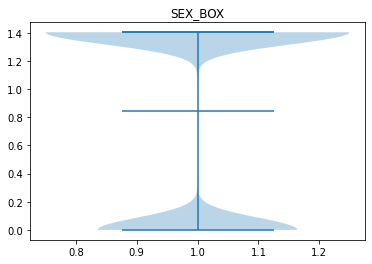

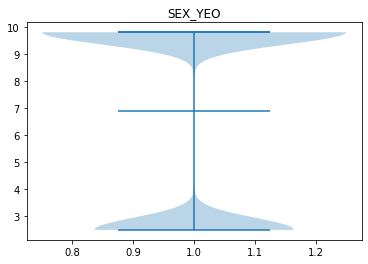

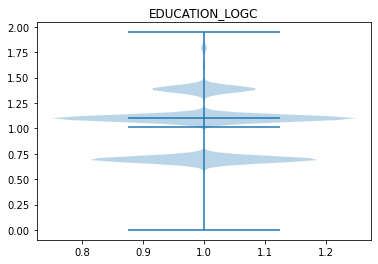

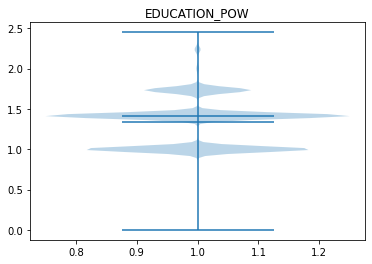

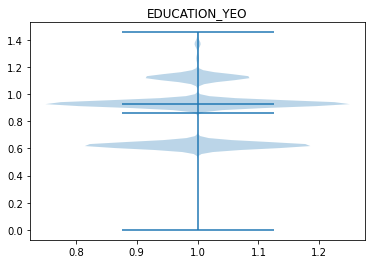

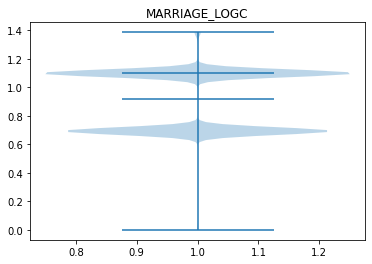

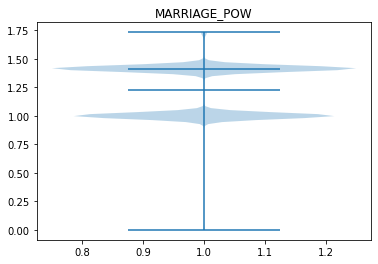

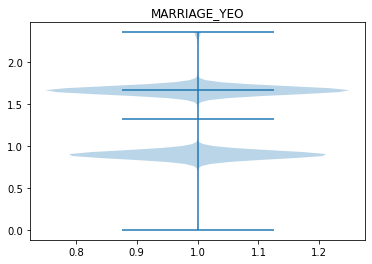

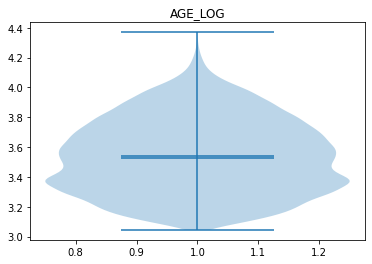

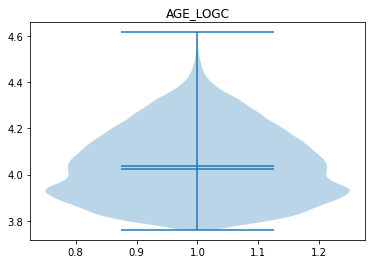

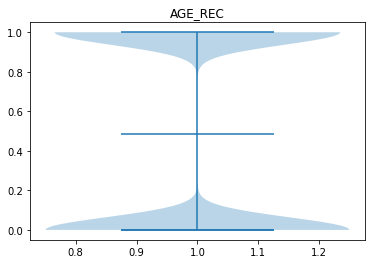

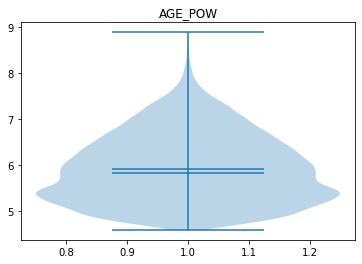

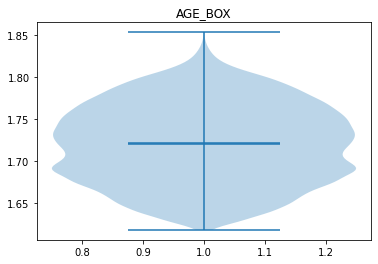

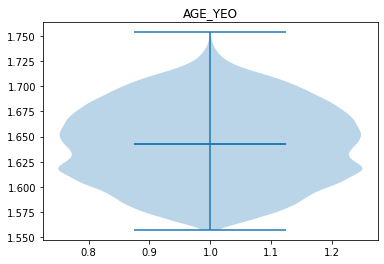

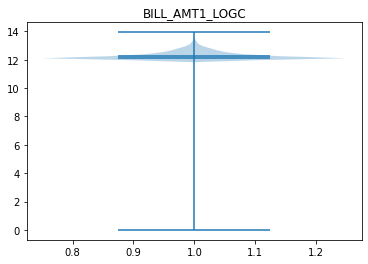

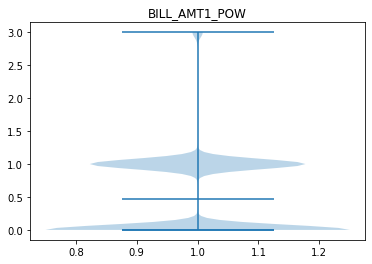

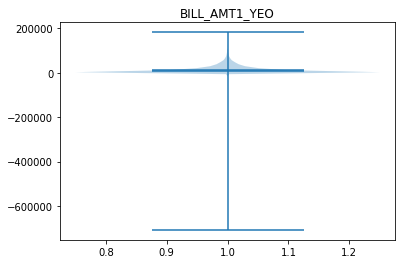

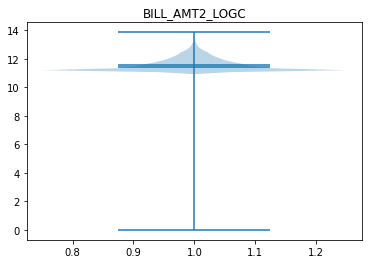

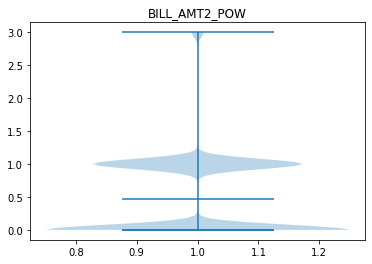

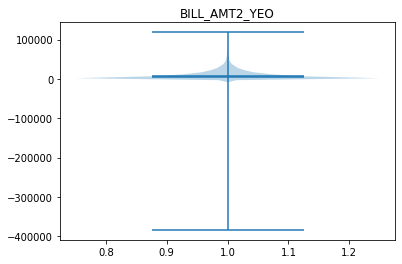

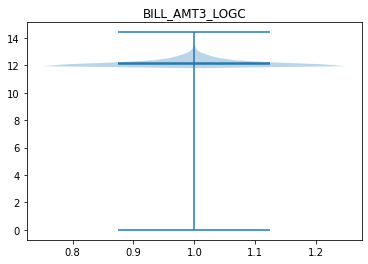

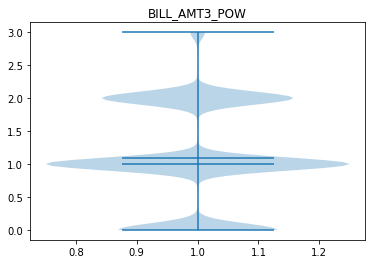

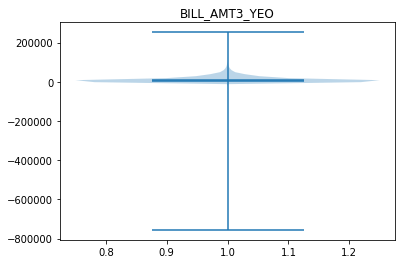

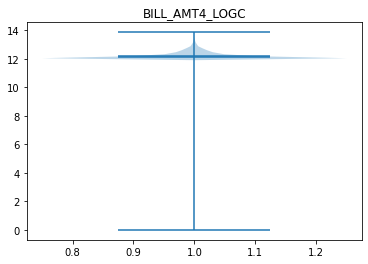

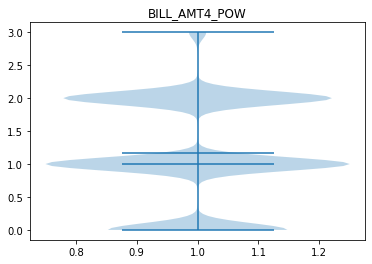

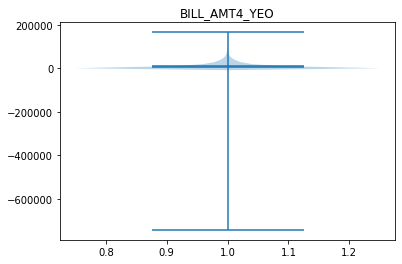

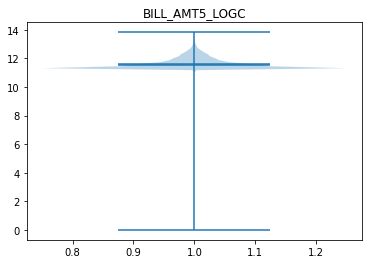

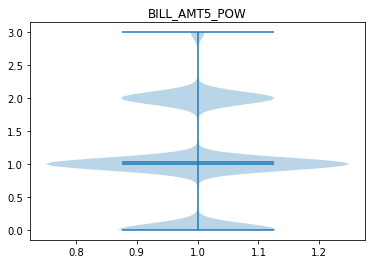

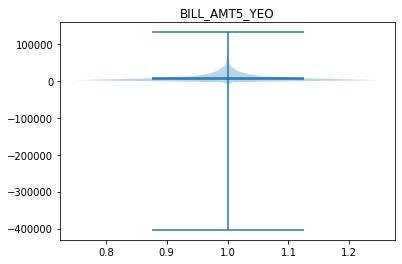

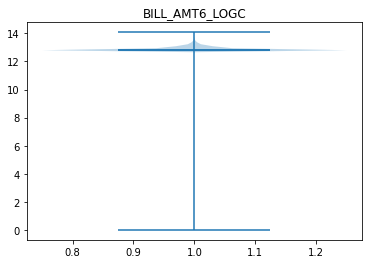

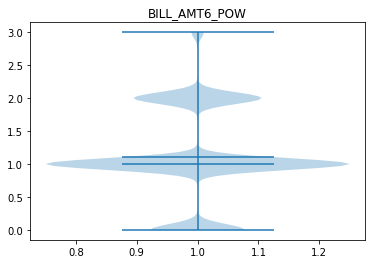

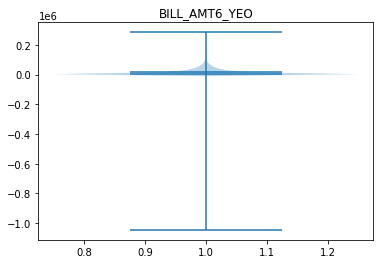

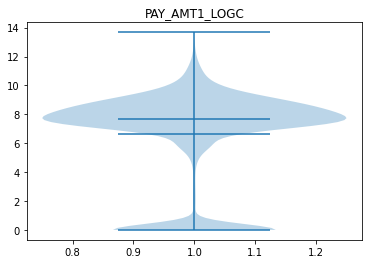

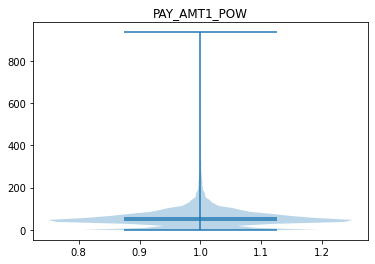

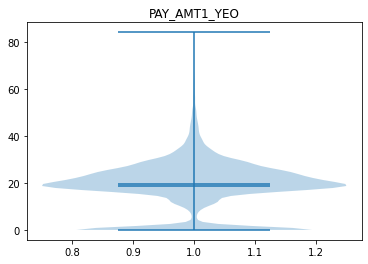

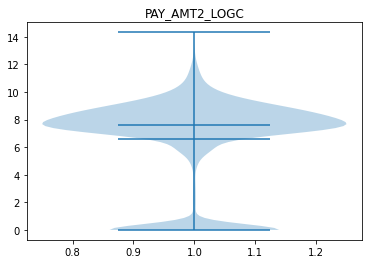

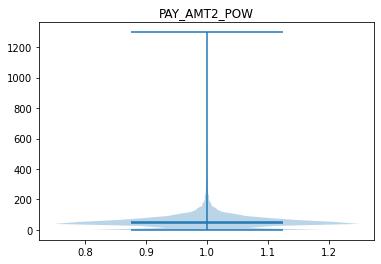

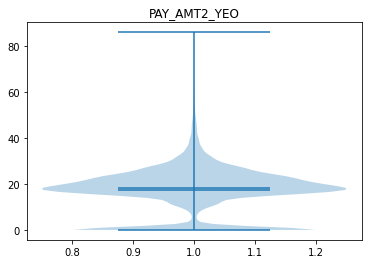

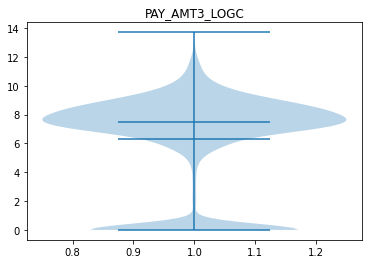

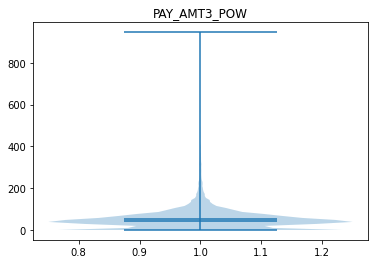

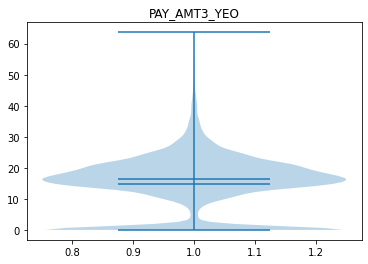

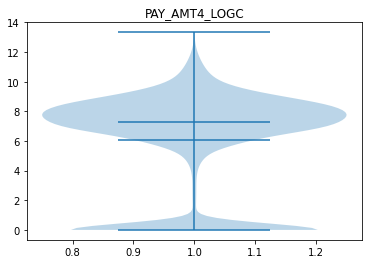

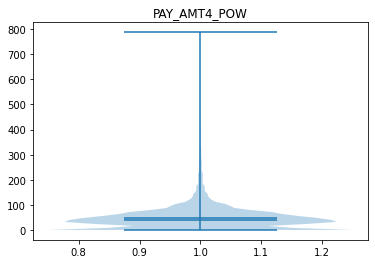

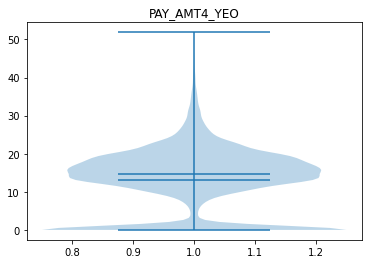

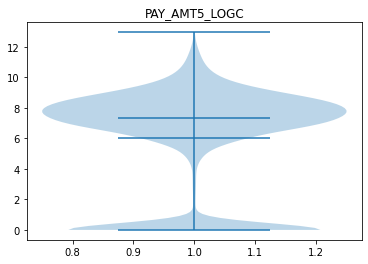

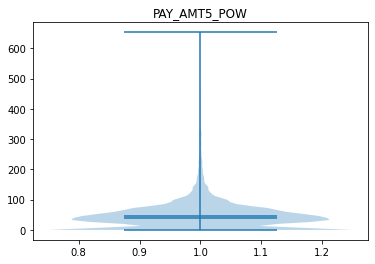

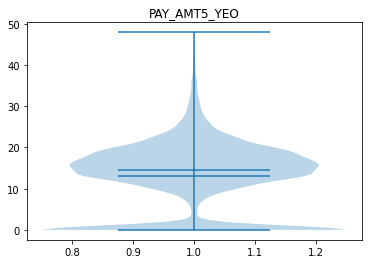

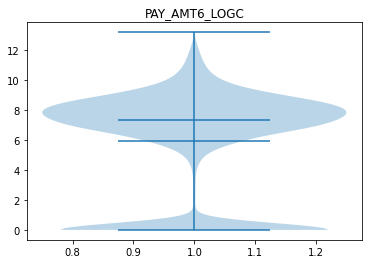

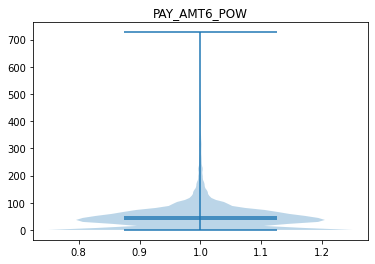

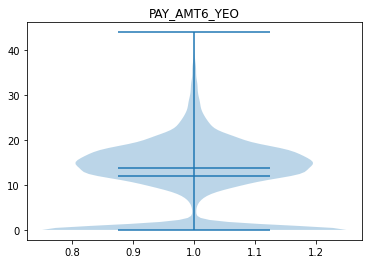

In [98]:
for col in df.columns:
    if df[col].dtype == 'object':
        sns.catplot(x=col, kind='count', data=df)
        plt.xticks(rotation=90)
    else:
        fig = plt.figure()
        plt.violinplot(df[col], showmeans=True, showextrema=True, showmedians=True)
        plt.title(col)
        plt.show()  

In [99]:
print(df_des.alvo.value_counts())
print("\nDefaults representam {:.4f}% do dataset.\n".format((df_des[df_des.alvo == 1].shape[0] / df_des.shape[0]) * 100))

0    19354
1     5458
Name: alvo, dtype: int64

Defaults representam 21.9974% do dataset.



In [51]:
# vars_presel = {}
# for var in selecionadas2:
#     x = df[var].values
#     y = df['alvo']

#     optb = OptimalBinning(
#             name = var,
#             prebinning_method = 'cart',
#             divergence ='iv',
#             dtype = "numerical",
#             solver = "cp",
#             monotonic_trend = "descending",
#             gamma = 0.5,
#             max_n_bins = 10,
#             min_n_bins = 2)

#     optb.fit(x, y)
#     if optb.status ==  'OPTIMAL':
        
#         binning_table = optb.binning_table
#         display(binning_table.build()) ####
#         vars_presel[var] = binning_table.build().loc['Totals', 'IV']
#         binning_table.plot(metric="event_rate") ####

#         binning_table.plot(metric="woe") ####

#         x_transform_bins = optb.transform(x, metric="bins")
#         display(pd.Series(x_transform_bins).value_counts())

# display(vars_presel)


In [53]:
for col in X_train_transf[selecionadas2].columns.values:
    print(col, X_train_transf[col].unique(), '---',  len(X_train_transf[col].unique()))

EDUCATION ["['others' 'missing' 'graduate school']" "['university']"
 "['high school']"] --- 3
PAY_0 ["['0']" "['-1']" "['2' '3+']" "['-2']" "['1']"] --- 5
PAY_3 ["['0']" "['-1']" "['2' '3+']" "['-2' '1']"] --- 4
PAY_5 ["['0']" "['-1']" "['2' '3+']" "['-2']"] --- 4
PAY_AMT4 ['[15092.50, inf)' '[0.50, 2004.50)' '[4000.50, 15092.50)'
 '[2004.50, 4000.50)' '(-inf, 0.50)'] --- 5
LIMIT_BAL_YEO ['[111.07, inf)' '[61.79, 82.46)' '[94.66, 111.07)' '[82.46, 94.66)'
 '(-inf, 61.79)'] --- 5
AGE_LOGC ['[3.92, 4.03)' '(-inf, 3.86)' '[4.21, inf)' '[3.86, 3.92)' '[4.03, 4.21)'] --- 5
BILL_AMT1_POW ['[445.94, inf)' '[14.37, 233.25)' '[301.07, 445.94)' 'Missing'
 '(-inf, 14.37)' '[233.25, 301.07)'] --- 6
BILL_AMT4_POW ['[129.02, inf)' '(-inf, 28.35)' '[88.33, 129.02)' '[50.00, 88.33)'
 '[28.35, 50.00)' 'Missing'] --- 6
BILL_AMT5_POW ['[92.19, inf)' 'Missing' '[52.12, 92.19)' '(-inf, 18.88)'
 '[32.41, 52.12)' '[18.88, 32.41)'] --- 6
BILL_AMT6_POW ['[113.42, inf)' '[18.53, 50.54)' '[76.58, 113.42)' '[50.

fazer sinos by 0 e 1 do alvo

fazer análise que identifica variaveis numericas e categoricas e as divide nas análises iniciais

ver se faz sentido os coeficinetes betas

analisar woes na safra
